# Benckmarking Dataset 5

In [8]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import time
import logging
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import shutil
from sklearn.metrics.pairwise import cosine_similarity

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')
from utils import *

# Preprocessing STARmap PLUS Hippocampus 3D data
We use a single-cell resolution STARmap PLUS Hippocampus 3D dataset to generate a simulated dataset. The raw STARmap dataset is available in [here](https://singlecell.broadinstitute.org/single_cell/study/SCP1375). Conveniently, we provided the pre-pocessed benchmarking Dataset 5 (demo_data/starmap_plus_3D.h5ad and demo_data/starmap_plus_scref.h5ad) as well as other relevent materials involved in the following example in [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg?usp=sharing)

In [2]:
sp_adata = sc.read('../demo_data/starmap_plus_3D.h5ad')
sc_adata = sc.read('../demo_data/starmap_plus_scref.h5ad')

In [155]:
sp_adata.obs['ct_top'].value_counts()

CTX-Ex    5369
Oligo     2883
DG        2693
Astro     1696
CA1       1377
Inh       1214
Endo      1064
CA3        815
SMC        632
Micro      624
CA2        498
OPC        330
LHb         36
Name: ct_top, dtype: int64

In [3]:
color_dict = {'Astro': '#1f77b4',
 'CA1': '#ff7f0e',
 'CA2': '#2ca02c',
 'CA3': '#d62728',
 'CTX-Ex': '#9467bd',
 'DG': '#8c564b',
 'Endo': '#e377c2',
 'Inh': '#7f7f7f',
 'LHb': '#bcbd22',
 'Micro': '#17becf',
 'OPC': '#f7b6d2',
 'Oligo': '#ffbb78',
 'SMC': '#c5b0d5'}
labelnames = ['Astro',
 'CA1',
 'CA2',
 'CA3',
 'CTX-Ex',
 'DG',
 'Endo',
 'Inh',
 'LHb',
 'Micro',
 'OPC',
 'Oligo',
 'SMC']

In [157]:
sp_adata.obs['ct_top'].map(color_dict)

1        #c5b0d5
3        #c5b0d5
4        #c5b0d5
5        #1f77b4
6        #c5b0d5
          ...   
50114    #c5b0d5
50115    #9467bd
50117    #9467bd
50119    #bcbd22
50120    #1f77b4
Name: ct_top, Length: 19231, dtype: category
Categories (13, object): ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', ..., '#17becf', '#f7b6d2', '#ffbb78', '#c5b0d5']

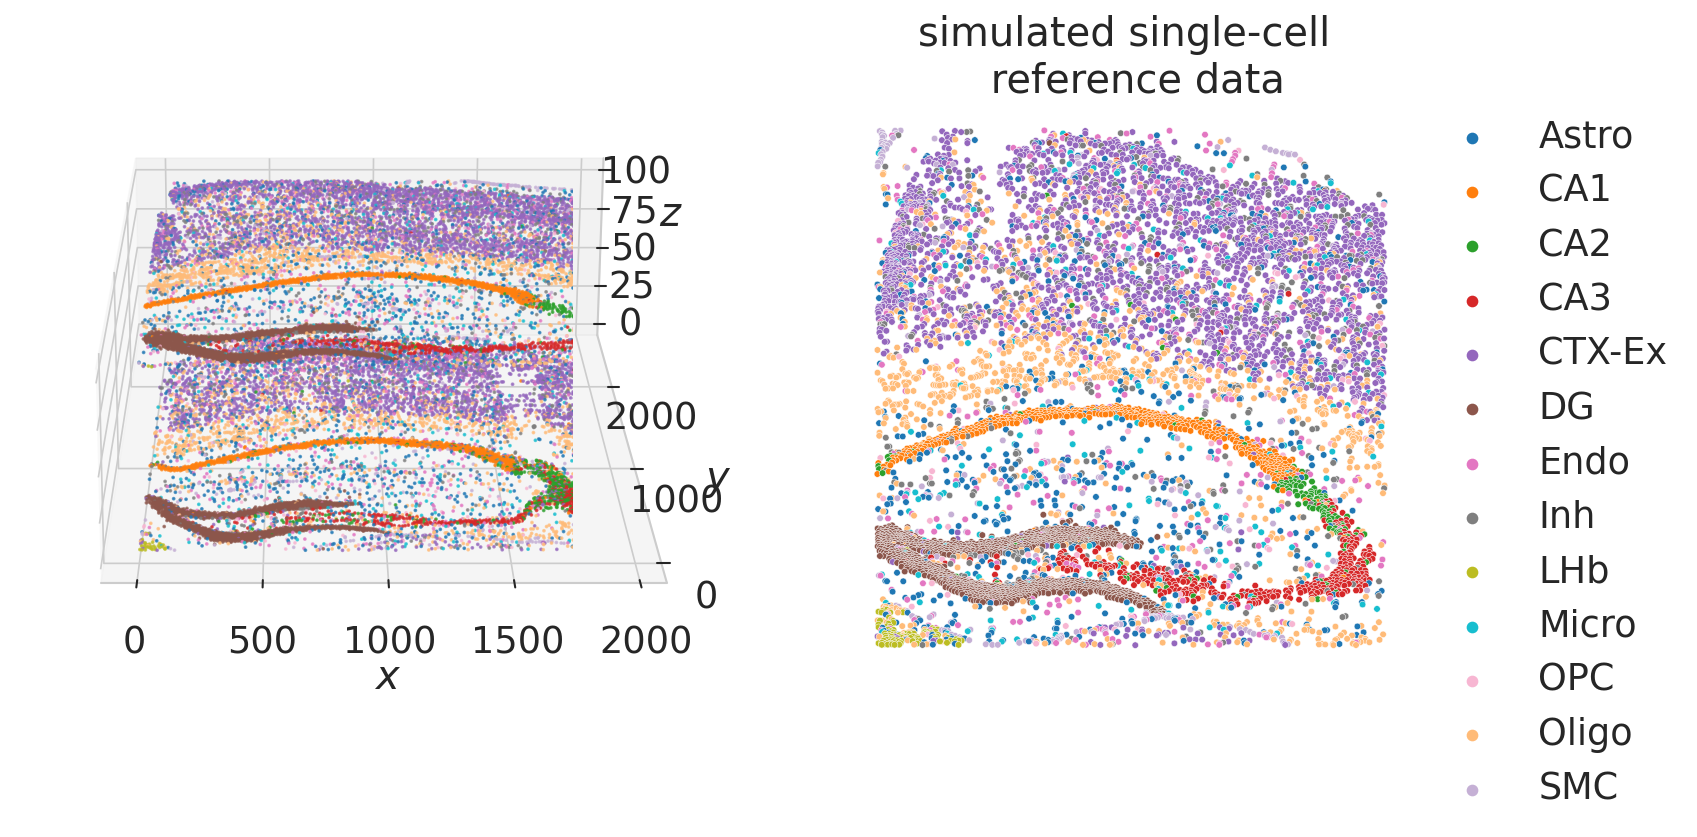

In [158]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = sp_adata.obsm['spatial_align'][:,0], \
            sp_adata.obsm['spatial_align'][:,1], \
            sp_adata.obsm['spatial_align'][:,2]

plt.figure(figsize=(12, 5),dpi = 150)
ax = plt.subplot(1,2,1, projection='3d')
ax1 = plt.subplot(1,2,2)

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

ax.scatter(x1, y1, z1, c=sp_adata.obs['ct_top'].map(color_dict), s=1., alpha=0.7)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

plt.gca().invert_yaxis()

ax.view_init(20,-90)


sns.scatterplot(data=sc_adata.obs, x="x", y="y", hue='ct_top', s = 10, palette = color_dict, ax = ax1)
ax1.set_title('simulated single-cell \n reference data')
ax1.invert_yaxis()
ax1.axis('off')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace = 0.5)
plt.show()

# Generate fake spatial data 

In [4]:
sp_adata = sc.read('../demo_data/starmap_plus_3D.h5ad')
sc_adata = sc.read('../demo_data/starmap_plus_scref.h5ad')
sp_cell_class_column = cell_class_column = 'ct_top'

In [5]:
sample1, sample2 = np.unique(sp_adata.obs['sample'])
print(f'sample1 name: {sample1}')
print(f'sample2 name: {sample2}')

slice1 = sp_adata.copy()[sp_adata.obs['sample'] == sample1]
slice2 = sp_adata.copy()[sp_adata.obs['sample'] == sample2]
slice1.uns['cell_locations'] = slice1.uns['cell_locations'][slice1.uns['cell_locations']['sample'] == sample1]
slice2.uns['cell_locations'] = slice2.uns['cell_locations'][slice2.uns['cell_locations']['sample'] == sample2]

print(f'slice1 shape: {slice1.shape}')
print(f'slice2 shape: {slice2.shape}')

sample1 name: 13months-control-replicate_2
sample2 name: 8months-control-replicate_2
slice1 shape: (9428, 2766)
slice2 shape: (9803, 2766)


In [7]:
x_min = sp_adata.obs['x'].min()
x_max = sp_adata.obs['x'].max()
y_min = sp_adata.obs['y'].min()
y_max = sp_adata.obs['y'].max()

num_x = 60
num_y = 76

# make grid 
x_seg = np.linspace(x_min, x_max, num_x)
y_seg = np.linspace(y_min, y_max, num_y)

print((x_min, x_max), (y_min, y_max))
print(y_max - y_min, x_max - x_min, (y_max - y_min) / (x_max - x_min))
print(x_seg[1] - x_seg[0], y_seg[1] - y_seg[0])

(0.0, 1962.3) (0.0, 2528.1)
2528.1 1962.3 1.288335116954594
33.25932203389831 33.708


In [8]:
mean_UMI = sp_adata.X.sum(1).mean()
print(mean_UMI)
sample_UMIs = [int(0.5 * mean_UMI), int(1.0 * mean_UMI), int(2.0 * mean_UMI)]
print(sample_UMIs)

176.20123
[88, 176, 352]


In [9]:
base_path = '/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS'
if not os.path.exists(base_path):
    os.mkdir(base_path)
base_path = os.path.join(base_path, str(num_x) + 'x' + str(num_y))
if not os.path.exists(base_path):
    os.mkdir(base_path)

for sample_UMI in sample_UMIs:
    save_data_dir = os.path.join(base_path, f'{int(sample_UMI)}UMI')
    print(save_data_dir)
    if not os.path.exists(save_data_dir):
        os.mkdir(save_data_dir)

/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/88UMI
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/352UMI


## Generate fake spatial data for 3D (concat spatial data of each single slice in 3d slices)

In [65]:
base_path

'/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76'

In [69]:
z = 50
for sample_UMI in sample_UMIs:
    DataDir = os.path.join(base_path, f'{int(sample_UMI)}UMI')
    DataDir_Slice1 = os.path.join(DataDir, 'slice1')
    DataDir_Slice2 = os.path.join(DataDir, 'slice2')
    
    sp_adata_slice1 = sc.read(os.path.join(DataDir_Slice1, 'spatial.h5ad'))
    sp_adata_slice2 = sc.read(os.path.join(DataDir_Slice2, 'spatial.h5ad'))
    
    # add z dimension
    for i, single_slice in enumerate([sp_adata_slice1, sp_adata_slice2]):
        single_slice.obsm['spatial'] = np.hstack((single_slice.obsm['spatial'],
                                                   i * z * np.ones((single_slice.obsm['spatial'].shape[0],1))))
        single_slice.obs['z'] = i * z * np.ones((single_slice.obs.shape[0],1))
        single_slice.uns['cell_locations']['z'] = i * z * np.ones((single_slice.uns['cell_locations'].shape[0],1))
        
    # concatenate spot index 
    spatial_adata = sp_adata_slice1.copy().concatenate(sp_adata_slice2.copy())

    temp = sp_adata_slice2.uns['cell_locations'].copy()
    temp.spot_index_int = temp.spot_index_int + sp_adata_slice1.uns['cell_locations'].spot_index_int[-1] + 1

    cell_index = []
    for i in np.unique(temp['spot_index_int']):
        ind = temp['spot_index_int'] == i
        for j in range(ind.sum(0)):
            cell_index  = cell_index + ['spot_' + str(i) + '_' + str(j)]
    temp['cell_index'] =  cell_index   
    temp['spot_index'] =  ['spot_' + str(_) for _ in temp.spot_index_int]

    cell_locations = pd.concat([sp_adata_slice1.uns['cell_locations'].copy(), temp], axis = 0)
    spatial_adata.uns['cell_locations'] = cell_locations.copy()

    sp_index = np.array(KeepOrderUnique(cell_locations['spot_index']))
    spatial_adata.obs.index = sp_index

    sample_names = [sample1, sample2]
    spatial_adata.obs['sample'] = [sample_names[0] if _ == '0' else sample_names[1] for _ in spatial_adata.obs.batch]
    
    # save data 
    save_data_dir = DataDir
    
    ## spatial
    save_sp_dir = os.path.join(save_data_dir, 'spatial.h5ad')
    print(f'saved simulated spatial data of subsample {sample_UMI} UMI in {save_sp_dir}')
    spatial_adata.write(save_sp_dir)

saved simulated spatial data of subsample 88 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/88UMI/spatial.h5ad
saved simulated spatial data of subsample 176 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/spatial.h5ad
saved simulated spatial data of subsample 352 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/352UMI/spatial.h5ad


### 2 slices add together without z dimension (3D_single), just like run slices one by one and can not borrow information from other slices

In [144]:
for sample_UMI in sample_UMIs:
    DataDir = os.path.join(base_path, f'{int(sample_UMI)}UMI')
    DataDir_Slice1 = os.path.join(DataDir, 'slice1')
    DataDir_Slice2 = os.path.join(DataDir, 'slice2')
    
    sp_adata_slice1 = sc.read(os.path.join(DataDir_Slice1, 'spatial.h5ad'))
    sp_adata_slice2 = sc.read(os.path.join(DataDir_Slice2, 'spatial.h5ad'))
    
    # concatenate spot index 
    spatial_adata = sp_adata_slice1.copy().concatenate(sp_adata_slice2.copy())

    temp = sp_adata_slice2.uns['cell_locations'].copy()
    temp.spot_index_int = temp.spot_index_int + sp_adata_slice1.uns['cell_locations'].spot_index_int[-1] + 1

    cell_index = []
    for i in np.unique(temp['spot_index_int']):
        ind = temp['spot_index_int'] == i
        for j in range(ind.sum(0)):
            cell_index  = cell_index + ['spot_' + str(i) + '_' + str(j)]
    temp['cell_index'] =  cell_index   
    temp['spot_index'] =  ['spot_' + str(_) for _ in temp.spot_index_int]

    cell_locations = pd.concat([sp_adata_slice1.uns['cell_locations'].copy(), temp], axis = 0)
    spatial_adata.uns['cell_locations'] = cell_locations.copy()

    sp_index = np.array(KeepOrderUnique(cell_locations['spot_index']))
    spatial_adata.obs.index = sp_index

    sample_names = [sample1, sample2]
    spatial_adata.obs['sample'] = [sample_names[0] if _ == '0' else sample_names[1] for _ in spatial_adata.obs.batch]
    
#     # save data 
#     save_data_dir = os.path.join(DataDir, '3D_single')
    
#     ## spatial
#     save_sp_dir = os.path.join(save_data_dir, 'spatial.h5ad')
#     print(f'saved simulated spatial data of subsample {sample_UMI} UMI in {save_sp_dir}')
#     spatial_adata.write(save_sp_dir)

saved simulated spatial data of subsample 88 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/88UMI/3D_single/spatial.h5ad
saved simulated spatial data of subsample 176 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/3D_single/spatial.h5ad
saved simulated spatial data of subsample 352 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/352UMI/3D_single/spatial.h5ad


# SpatialScope 3D

```
#!/bin/bash 

set -o pipefail
set -exu


for rep in {0..9}
# for rep in {1..9}

do 

for i in 0 0.000001 5 10 20 30 40 50 60 70 80 90 100 120 150 200 500 1000

do

python ./src/Cell_Type_Identification.py \
--cell_class_column ct_top \
--tissue "rep$rep" \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/spatial.h5ad \
--SC_Data ../demo_data/starmap_plus_scref.h5ad \
--hs_ST \
--UMI_min_sigma 100 \
--find_neighbor_radius 20 \
--nu $i

done

done

for rep in {3..9}
do
cp /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep$rep/InitProp.pickle /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/3D_single/rep$rep
done
```


# StarDist + RCTD 

```
for rep in {0..9}

do 

python ./compared_methods/SDRCTD.py \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep$rep \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/spatial.h5ad \
--SC_Data ../demo_data/starmap_plus_scref.h5ad \
--cell_class_column ct_top \
--cell_num_column cell_nums \
--hs_ST \

done
```

# SpatialScope 2D

```
for rep in {0..9}

do 

for i in 0 0.000001 5 10 20 30 40 50 60 70 80 90 100 120 150 200 500 1000

do

python ./src/Cell_Type_Identification.py \
--cell_class_column ct_top \
--tissue "rep$rep" \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/3D_single \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/3D_single/spatial.h5ad \
--SC_Data ../demo_data/starmap_plus_scref.h5ad \
--hs_ST \
--UMI_min_sigma 100 \
--find_neighbor_radius 20 \
--nu $i

done
done


```


In [10]:
DataDir = os.path.join(base_path, str(sample_UMIs[1]) + 'UMI')
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))

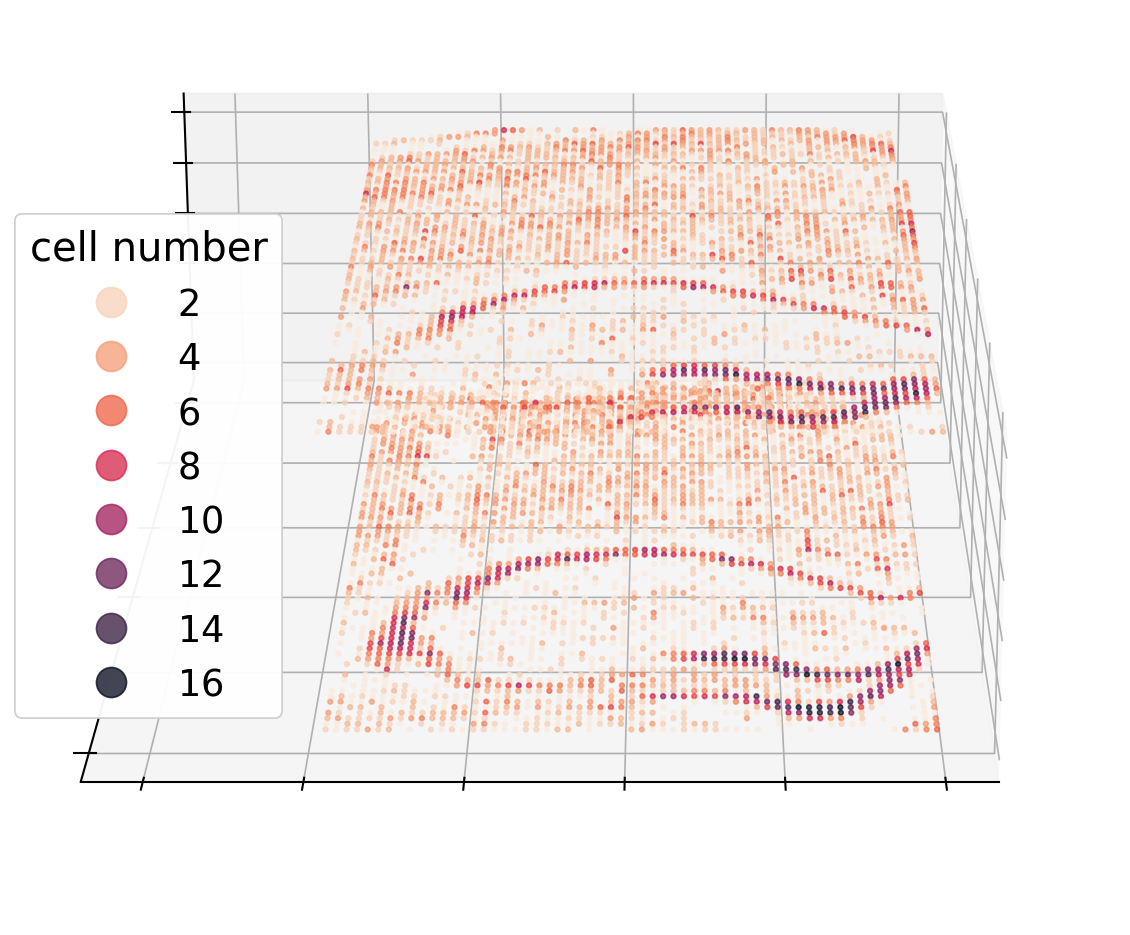

In [29]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = sp_adata.obsm['spatial'][:,0], \
            sp_adata.obsm['spatial'][:,1], \
            sp_adata.obsm['spatial'][:,2]

plt.figure(figsize=(20, 8),dpi = 150)
sns.set_context('paper',font_scale=2) 
ax = plt.subplot(1,1,1, projection='3d')

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

scatter = ax.scatter(x1, y1, z1, c=np.array(sp_adata.obs['cell_nums']), s=5., alpha=0.7, cmap = sns.color_palette("rocket_r", as_cmap=True))

# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])
    

plt.gca().invert_yaxis()
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="cell number")

legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'),
                    loc="upper right", title="cell number", bbox_to_anchor=(0.1,0.8), markerscale = 3)
ax.add_artist(legend1)

ax.view_init(20,-90)
plt.show()

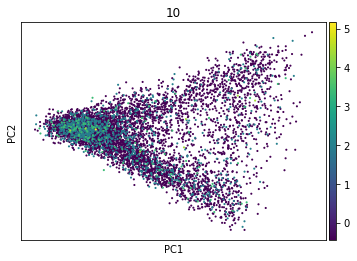

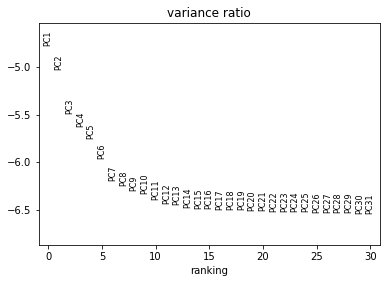

In [64]:
leiden_sp = sp_adata.copy()

sc.pp.log1p(leiden_sp)
sc.pp.scale(leiden_sp, max_value=10)
sc.tl.pca(leiden_sp, svd_solver='arpack')
sc.pl.pca(leiden_sp, color=sp_adata.var.index[10])
sc.pl.pca_variance_ratio(leiden_sp, log=True)
sc.pp.neighbors(leiden_sp, n_neighbors=10, n_pcs=40)
sc.tl.leiden(leiden_sp)

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('default')

sns.set_context('paper',font_scale=1.6) 

# with mpl.rc_context({'figure.figsize': (9, 9), 'figure.dpi': 150}):
#     ax = sns.scatterplot(data=leiden_sp.obs, x="x", y="y", hue='leiden', s = 110, palette = 'tab20')
# #     ax = sns.scatterplot(data=sp_adata.obs, x="X", y="Y", s = 50, palette = "rocket_r")
#     ax.invert_yaxis()
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     plt.legend(bbox_to_anchor=(1,0.6), title = 'cell number', markerscale = 3)

In [66]:
leiden_sp

AnnData object with n_obs × n_vars = 6792 × 2766
    obs: 'x', 'y', 'cell_nums', 'z', 'batch', 'sample', 'leiden'
    var: 'highly_variable', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean', 'std'
    uns: 'cell_locations', 'log1p', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

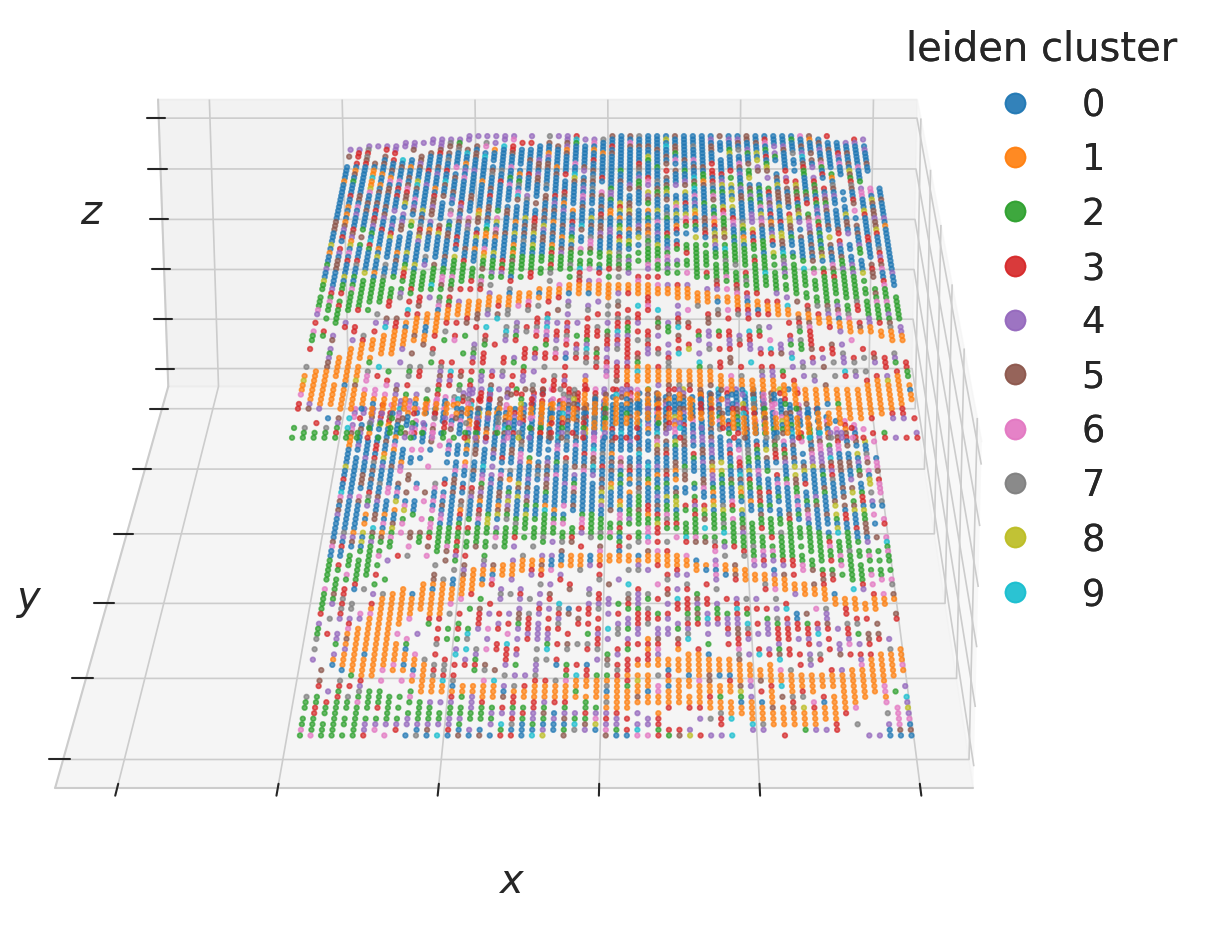

In [406]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = leiden_sp.obsm['spatial'][:,0], \
            leiden_sp.obsm['spatial'][:,1], \
            leiden_sp.obsm['spatial'][:,2]

plt.figure(figsize=(20, 8),dpi = 150)
ax = plt.subplot(1,1,1, projection='3d')

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

scatter = ax.scatter(x1, y1, z1, c=np.array(leiden_sp.obs['leiden']).astype(np.int), s=5., alpha=0.7, cmap = sns.color_palette("tab10", as_cmap=True))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="cell number")

legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'),
                    loc=(0.78, 0.33), title="leiden cluster", markerscale = 2)
ax.add_artist(legend1)

ax.view_init(20,-90)
plt.show()

## nu test

In [10]:
def ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim

def rmse(x1,x2):
    return mean_squared_error(x1,x2,squared=False)
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df


In [11]:
def label_to_matrix(spot_label, label):
    matrix = pd.DataFrame(index = np.unique(spot_label), columns = np.unique(np.array(label)))
    for i in np.unique(spot_label):
        each_spot_prop_df = pd.DataFrame(index = np.unique(np.array(label)))
        each_spot_prop_df['prop'] = np.zeros(each_spot_prop_df.shape[0])
        index = spot_label == i
        val, counts = np.unique(label[index], return_counts=True)
        each_spot_prop_df.loc[val, 'prop'] = counts
        matrix.loc[i,:] = each_spot_prop_df.values.squeeze()

    return matrix

gd_results = label_to_matrix(np.array(sp_adata.uns['cell_locations']['spot_index_int']), np.array(sp_adata.uns['cell_locations'][sp_cell_class_column]))
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)

In [12]:
DataDir

'/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI'

In [78]:
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))
sp_adata.obs[np.array(['x', 'y', 'z'])].to_csv(DataDir + '/gt_loc.txt')
gd_results.to_csv(DataDir + '/gt_res.txt')

## deconvolution

In [ ]:
nu_list = [0, 0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

decon_df = pd.DataFrame()
decon_pcc_df = pd.DataFrame()
decon_rmse_df = pd.DataFrame()

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
        
        ################################################################################################################## RCTD resutls
        with open(os.path.join(DataDir, 'rep' + str(rep), 'InitProp.pickle'), 'rb') as handle:
            InitProp = pickle.load(handle)

        RCTD_results = (InitProp['results'] / np.array(InitProp['results'].sum(1))[:, None])
        RCTD_results = RCTD_results.loc[:, np.unique(RCTD_results.columns)]
        if rep == 0:
            print(os.path.join(DataDir, 'rep' + str(rep), 'RCTD_results.txt'))
            RCTD_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'RCTD_results.txt'))
            
        ################################################################################################################## StarDist + RCTD resutls
        SR_results = sc.read(os.path.join(DataDir, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
        SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        prop = label_to_matrix(np.array(SR_cell_type_label['spot_index_int']), np.array(SR_cell_type_label['SDRCTD_cell_type']))
        prop = prop/prop.sum(1)[:,None]

        SR_results = prop
        SR_results.index = np.arange(len(SR_results))
        SR_results = SR_results.loc[:,np.unique(SR_results.columns)]

        if rep == 0:
            print(os.path.join(DataDir, 'rep' + str(rep), 'SR_results.txt'))
            SR_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'SR_results.txt'))

    ################################################################################################################## SpatialScope_3D resuslts
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_results = prop
        SpatialScope_results.index = np.arange(len(RCTD_results))
        SpatialScope_results = SpatialScope_results.loc[:,np.unique(SpatialScope_results.columns)]
        print(os.path.join(DataDir, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))
        SpatialScope_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))

   ################################################################################################################## SpatialScope resuslts     
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_3D_single_results = prop
        SpatialScope_3D_single_results.index = np.arange(len(SpatialScope_3D_single_results))
        SpatialScope_3D_single_results = SpatialScope_3D_single_results.loc[:,np.unique(SpatialScope_3D_single_results.columns)]

    ##################################################################################################################  
        RCTD_results = RCTD_results.loc[:,gd_results.columns]
        SR_results = SR_results.loc[:,gd_results.columns]
        SpatialScope_results = SpatialScope_results.loc[:,gd_results.columns]
        SpatialScope_3D_single_results = SpatialScope_3D_single_results.loc[:,gd_results.columns]  


        starmap_spots_pcc = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_3D_single_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope', 'SpatialScope_3D'],
            axis=0,
            metric='pcc'
        )

        starmap_spots_rmse = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_3D_single_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope', 'SpatialScope_3D'],
            axis=0,
            metric='rmse'
        )

        starmap_spots_pcc['nu'] = [nu] * starmap_spots_pcc.shape[0]
        starmap_spots_pcc['metric'] = ['pcc'] * starmap_spots_pcc.shape[0]
        starmap_spots_rmse['nu'] = [nu] * starmap_spots_rmse.shape[0]
        starmap_spots_rmse['metric'] = ['rmse'] * starmap_spots_rmse.shape[0]

        starmap_spots_pcc['cell_nums'] = starmap_spots_rmse['cell_nums'] = sp_adata.obs.cell_nums.tolist()

        decon_df = pd.concat([decon_df, starmap_spots_pcc, starmap_spots_rmse], axis = 0)
        decon_pcc_df = pd.concat([decon_pcc_df, starmap_spots_pcc], axis = 0)
        decon_rmse_df = pd.concat([decon_rmse_df, starmap_spots_rmse], axis = 0)        
        

nu = 0; rep = 0
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep0/RCTD_results.txt
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep0/SR_results.txt
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep0/SpatialScope_result_nu0.txt
nu = 0; rep = 1
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep1/SpatialScope_result_nu0.txt
nu = 0; rep = 2
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep2/SpatialScope_result_nu0.txt
nu = 0; rep = 3
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep3/SpatialScope_result_nu0.txt
nu = 0; rep = 4
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep4/SpatialScope_result_nu0.txt
nu = 0; rep = 5
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI/rep5/SpatialScope_result_nu0.txt
nu = 0; rep = 6
/home/share/xwanaf/sour_sep/revision/data/RCTDnv

In [193]:
0

0

In [194]:
decon_df

RCTD        SR  SpatialScope  SpatialScope_3D      nu metric  \
0     0.965089  0.956954      0.956954         0.956954     0.0    pcc   
1     0.963446  0.969124      0.933673         0.933673     0.0    pcc   
2     0.603031  0.633445      0.633445         0.633445     0.0    pcc   
3     0.926628  1.000000      1.000000         1.000000     0.0    pcc   
4     0.924129  1.000000      1.000000         1.000000     0.0    pcc   
...        ...       ...           ...              ...     ...    ...   
6816  0.118069  0.130744      0.226455         0.345916  1000.0   rmse   
6817  0.146795  0.175412      0.260177         0.282843  1000.0   rmse   
6818  0.261687  0.339683      0.392232         0.392232  1000.0   rmse   
6819  0.026451  0.000000      0.000000         0.000000  1000.0   rmse   
6820  0.055389  0.000000      0.000000         0.000000  1000.0   rmse   

      cell_nums  
0             6  
1             5  
2             5  
3             1  
4             4  
...         ...  
6816          3  
6817          5  
6818          2  
6819          1  
6820          2  

[2445120 rows x 7 columns]

In [196]:
decon_df.to_csv(os.path.join(DataDir, 'decon_df.csv'))
# error_rate_df.to_csv(os.path.join(DataDir, 'error_rate_df.csv'))

# error rate

In [188]:
DataDir

'/home/share/xwanaf/sour_sep/revision/data/RCTDnv_STARMAP_PLUS/60x76/176UMI'

In [198]:
nu_list = [0, 0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

error_rate_df = pd.DataFrame(columns = {'error_rate', 'nu', '3D', 'rep'})

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
            
        ################################################################################################################## StarDist + RCTD resutls
        if nu == 'RCTD':  
            SR_results = sc.read(os.path.join(DataDir, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
            SR_cell_type_label = SR_results.uns['cell_locations'].copy()
#             SR_cell_type_label = shuffle_cell_type_per_spot(SR_cell_type_label, 'SDRCTD_cell_type', sp_adata.shape[0])
            
#             SR_cell_type_label = SR_cell_type_label[SR_cell_type_label.cell_nums == 1]
        
            estimated = np.array(SR_cell_type_label['SDRCTD_cell_type'])
            tl = np.array(SR_cell_type_label[sp_cell_class_column])
            error_index = tl != estimated
            SR_cell_type_label['error'] = (error_index).astype(int) 
            RCTD_error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': RCTD_error_rate, 'nu': nu, '3D': False, 'rep': int(rep)}
        
        ################################################################################################################## StarDist + RCTD error rate
        else:
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

#             cell_locations = cell_locations[cell_locations.cell_nums == 1]
            
            estimated = np.array(cell_locations['discrete_label_ct'])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            if isinstance(nu, int):
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), '3D': True, 'rep': int(rep)}
            else:
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': nu, '3D': True, 'rep': int(rep)}    
                
            ####################################################################################################################################
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

#             cell_locations = cell_locations[cell_locations.cell_nums == 1]
            
            estimated = np.array(cell_locations['discrete_label_ct'])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            if isinstance(nu, int):
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), '3D': False, 'rep': int(rep)}
            else:
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': nu, '3D': False, 'rep': int(rep)}      
        

nu = 0; rep = 0
nu = 0; rep = 1
nu = 0; rep = 2
nu = 0; rep = 3
nu = 0; rep = 4
nu = 0; rep = 5
nu = 0; rep = 6
nu = 0; rep = 7
nu = 0; rep = 8
nu = 0; rep = 9
nu = 1e-06; rep = 0
nu = 1e-06; rep = 1
nu = 1e-06; rep = 2
nu = 1e-06; rep = 3
nu = 1e-06; rep = 4
nu = 1e-06; rep = 5
nu = 1e-06; rep = 6
nu = 1e-06; rep = 7
nu = 1e-06; rep = 8
nu = 1e-06; rep = 9
nu = 5; rep = 0
nu = 5; rep = 1
nu = 5; rep = 2
nu = 5; rep = 3
nu = 5; rep = 4
nu = 5; rep = 5
nu = 5; rep = 6
nu = 5; rep = 7
nu = 5; rep = 8
nu = 5; rep = 9
nu = 10; rep = 0
nu = 10; rep = 1
nu = 10; rep = 2
nu = 10; rep = 3
nu = 10; rep = 4
nu = 10; rep = 5
nu = 10; rep = 6
nu = 10; rep = 7
nu = 10; rep = 8
nu = 10; rep = 9
nu = 20; rep = 0
nu = 20; rep = 1
nu = 20; rep = 2
nu = 20; rep = 3
nu = 20; rep = 4
nu = 20; rep = 5
nu = 20; rep = 6
nu = 20; rep = 7
nu = 20; rep = 8
nu = 20; rep = 9
nu = 30; rep = 0
nu = 30; rep = 1
nu = 30; rep = 2
nu = 30; rep = 3
nu = 30; rep = 4
nu = 30; rep = 5
nu = 30; rep = 6
nu = 30; rep = 7
nu =

In [199]:
error_rate_df.to_csv(os.path.join(DataDir, 'error_rate_df.csv'))

In [11]:
error_rate_df = pd.read_csv(os.path.join(DataDir, 'error_rate_df.csv'), index_col = 0)

In [12]:
error_rate_df

error_rate  rep     3D    nu
0      0.445995    0   True   0.0
1      0.445370    0  False   0.0
2      0.445006    1   True   0.0
3      0.445735    1  False   0.0
4      0.446308    2   True   0.0
..          ...  ...    ...   ...
365    0.447818    5  False  RCTD
366    0.443860    6  False  RCTD
367    0.449953    7  False  RCTD
368    0.450266    8  False  RCTD
369    0.455578    9  False  RCTD

[370 rows x 4 columns]

In [13]:
0

0

In [14]:
np.unique(error_rate_df['nu'])

array(['0.0', '10.0', '100.0', '1000.0', '120.0', '150.0', '1e-06',
       '20.0', '200.0', '30.0', '40.0', '5.0', '50.0', '500.0', '60.0',
       '70.0', '80.0', '90.0', 'RCTD'], dtype=object)

## error rate 

In [15]:
temp = error_rate_df.copy()[error_rate_df['nu'] != '1e-06']

In [16]:
vis_nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['StarDist \n + RCTD']

In [17]:
temp

error_rate  rep     3D    nu
0      0.445995    0   True   0.0
1      0.445370    0  False   0.0
2      0.445006    1   True   0.0
3      0.445735    1  False   0.0
4      0.446308    2   True   0.0
..          ...  ...    ...   ...
365    0.447818    5  False  RCTD
366    0.443860    6  False  RCTD
367    0.449953    7  False  RCTD
368    0.450266    8  False  RCTD
369    0.455578    9  False  RCTD

[350 rows x 4 columns]

In [274]:
gap_df = temp.copy().pivot_table(values = 'error_rate', columns = 'nu', index = '3D')
gap_df = pd.DataFrame(gap_df.iloc[1,:-1] - gap_df.iloc[0,:-1], columns = ['gap'])
gap_df =  gap_df.loc[np.array([0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000]).astype(float).astype(str),:]
gap_df['RCTD'] = 

In [275]:
gap_df

gap
nu              
0.0    -0.000042
5.0    -0.006426
10.0   -0.006312
20.0   -0.005302
30.0   -0.002614
40.0   -0.002234
50.0   -0.000672
60.0    0.000760
70.0    0.000354
80.0    0.001245
90.0    0.001765
100.0   0.002250
120.0   0.002729
150.0   0.002567
200.0   0.002364
500.0   0.003224
1000.0  0.046292

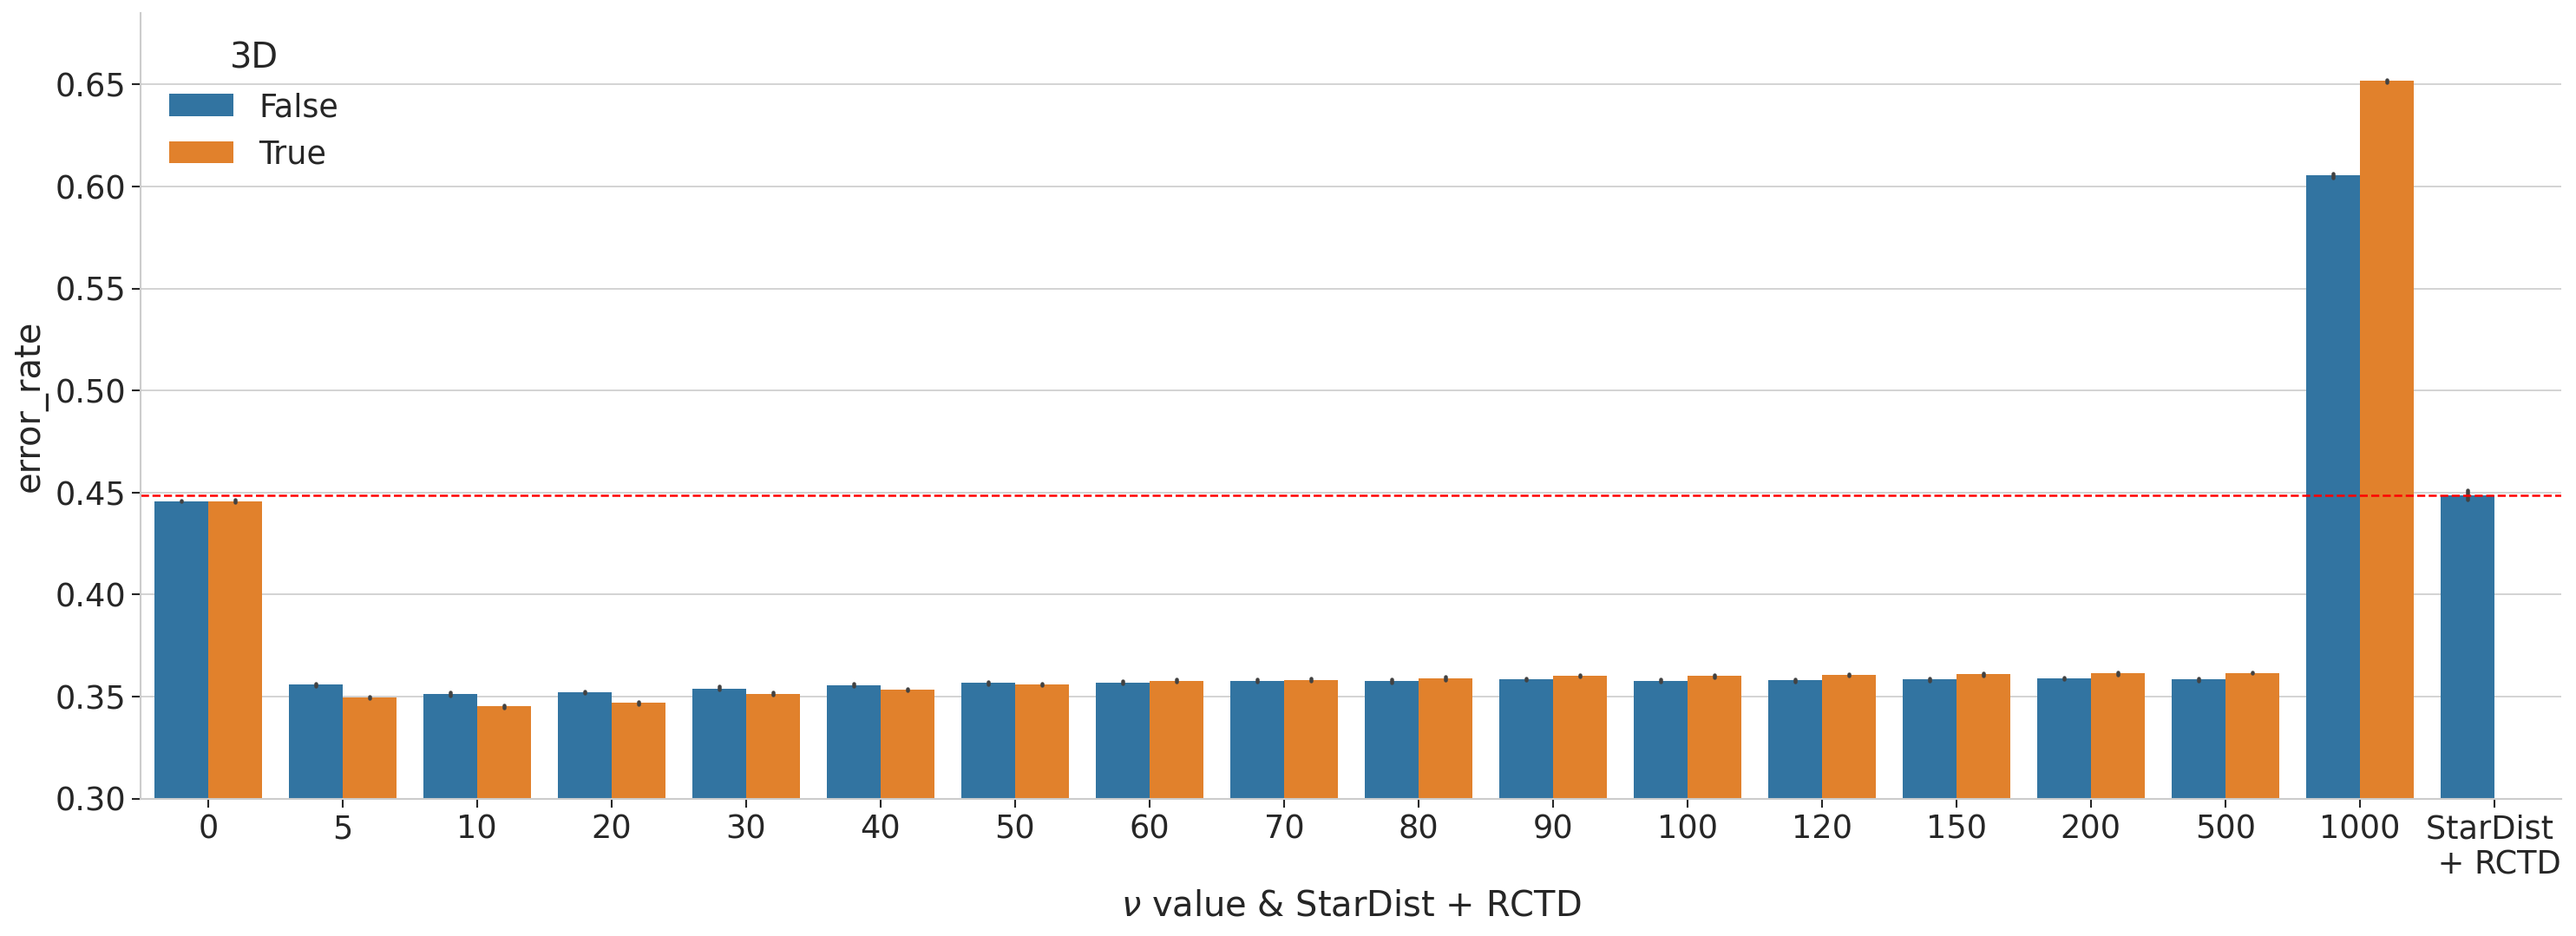

In [245]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (24, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette="tab10", ax = ax)
ax.set_ylim(0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

In [298]:
temp

error_rate  rep     3D    nu
0      0.445995    0   True   0.0
1      0.445370    0  False   0.0
2      0.445006    1   True   0.0
3      0.445735    1  False   0.0
4      0.446308    2   True   0.0
..          ...  ...    ...   ...
365    0.447818    5  False  RCTD
366    0.443860    6  False  RCTD
367    0.449953    7  False  RCTD
368    0.450266    8  False  RCTD
369    0.455578    9  False  RCTD

[350 rows x 4 columns]

In [330]:
temp_df = temp.copy().pivot_table(values = 'error_rate', columns = 'nu', index = '3D')
temp_df.iloc[:,:-1] =  temp_df.iloc[:,:-1].loc[:,np.array([0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000]).astype(float).astype(str)]
temp_df = temp_df.T
temp_df['nu'] = temp_df.index.tolist()
temp_df = temp_df.melt(id_vars = ['nu']).iloc[:-1,:]
temp_df['palette'] = '0'
index_2D = temp_df['3D'] == False
index_3D = temp_df['3D'] == True
temp_df['palette'][index_2D] = '#EB8E83'
temp_df['palette'][index_3D] = '#A02439'
temp_df['palette'][temp_df['nu'] == 'RCTD'] = '#D8A8EB'
temp_df

nu     3D     value  palette
0      0.0  False  0.445834  #EB8E83
1     10.0  False  0.355947  #EB8E83
2    100.0  False  0.351484  #EB8E83
3   1000.0  False  0.352271  #EB8E83
4    120.0  False  0.354057  #EB8E83
5    150.0  False  0.355692  #EB8E83
6     20.0  False  0.356671  #EB8E83
7    200.0  False  0.357015  #EB8E83
8     30.0  False  0.357911  #EB8E83
9     40.0  False  0.357775  #EB8E83
10     5.0  False  0.358582  #EB8E83
11    50.0  False  0.357874  #EB8E83
12   500.0  False  0.357963  #EB8E83
13    60.0  False  0.358379  #EB8E83
14    70.0  False  0.359124  #EB8E83
15    80.0  False  0.358385  #EB8E83
16    90.0  False  0.605380  #EB8E83
17    RCTD  False  0.448761  #D8A8EB
18     0.0   True  0.445792  #A02439
19    10.0   True  0.349521  #A02439
20   100.0   True  0.345172  #A02439
21  1000.0   True  0.346969  #A02439
22   120.0   True  0.351443  #A02439
23   150.0   True  0.353458  #A02439
24    20.0   True  0.355999  #A02439
25   200.0   True  0.357775  #A02439
26    30.0   True  0.358265  #A02439
27    40.0   True  0.359020  #A02439
28     5.0   True  0.360348  #A02439
29    50.0   True  0.360124  #A02439
30   500.0   True  0.360692  #A02439
31    60.0   True  0.360947  #A02439
32    70.0   True  0.361488  #A02439
33    80.0   True  0.361608  #A02439
34    90.0   True  0.651672  #A02439

In [348]:
temp_df = temp.copy().pivot_table(values = 'error_rate', columns = 'nu', index = '3D')
temp_df.iloc[:,:-1] =  temp_df.iloc[:,:-1].loc[:,np.array([0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000]).astype(float).astype(str)]
temp_df.columns = vis_nu_list[:-1] + ['RCTD']
temp_df

0         5        10        20        30        40        50  \
3D                                                                            
False  0.445834  0.355947  0.351484  0.352271  0.354057  0.355692  0.356671   
True   0.445792  0.349521  0.345172  0.346969  0.351443  0.353458  0.355999   

             60        70        80        90       100       120       150  \
3D                                                                            
False  0.357015  0.357911  0.357775  0.358582  0.357874  0.357963  0.358379   
True   0.357775  0.358265  0.359020  0.360348  0.360124  0.360692  0.360947   

            200       500      1000      RCTD  
3D                                             
False  0.359124  0.358385  0.605380  0.448761  
True   0.361488  0.361608  0.651672       NaN

In [349]:
temp_df_sd = temp.copy().pivot_table(values = 'error_rate', columns = 'nu', index = '3D', aggfunc = np.std)
temp_df_sd.iloc[:,:-1] =  temp_df_sd.iloc[:,:-1].loc[:,np.array([0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000]).astype(float).astype(str)]
temp_df_sd.columns = vis_nu_list[:-1] + ['RCTD']
temp_df_sd

0         5        10        20        30        40        50  \
3D                                                                            
False  0.000643  0.001147  0.001333  0.000824  0.001411  0.001064  0.000849   
True   0.001216  0.000858  0.001066  0.001229  0.000972  0.000990  0.000933   

             60        70        80        90       100       120       150  \
3D                                                                            
False  0.001105  0.000771  0.001134  0.000790  0.001130  0.001235  0.001123   
True   0.001099  0.001039  0.001151  0.001013  0.000884  0.000846  0.000815   

            200       500      1000      RCTD  
3D                                             
False  0.000682  0.001060  0.001573  0.003718  
True   0.000975  0.000533  0.001215       NaN

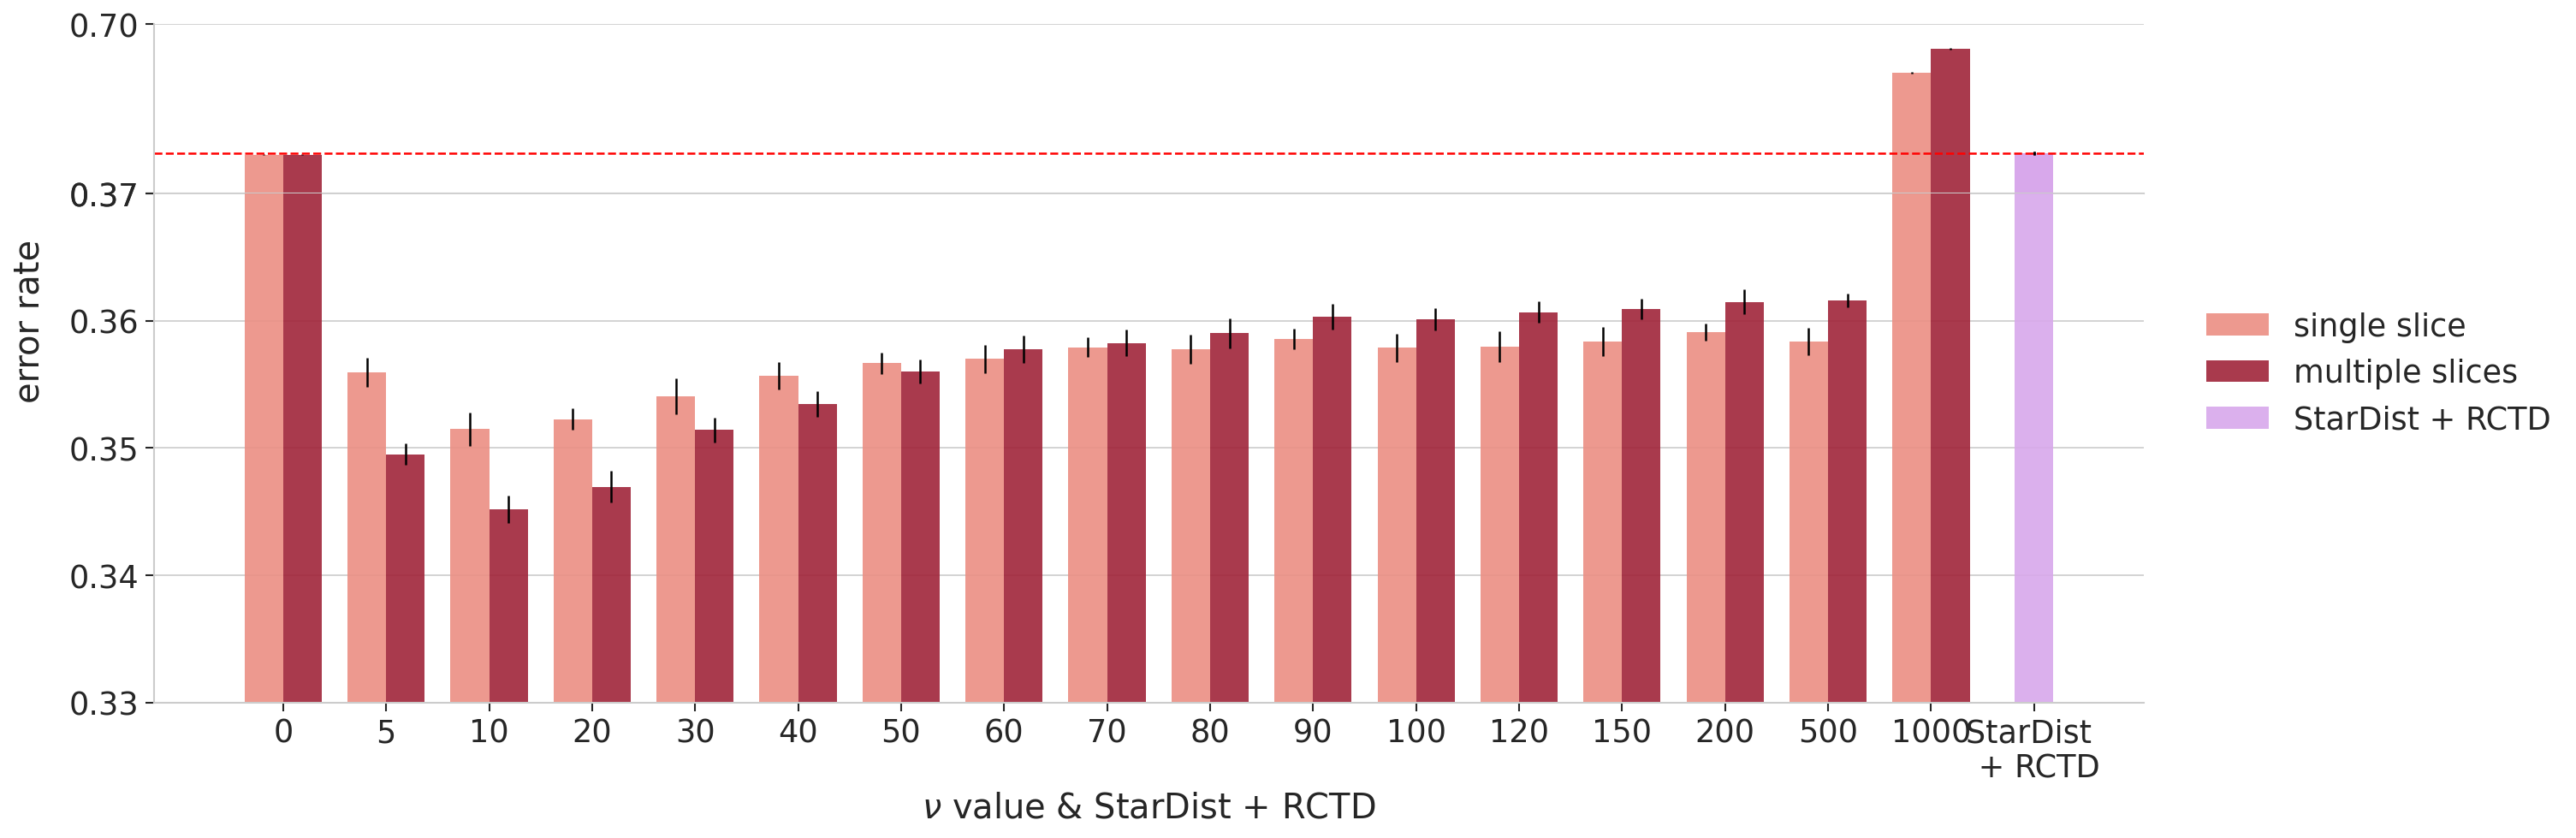

In [415]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid') # seaborn-whitegrid

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(2,1, figsize = (20, 7), dpi = 150, gridspec_kw={'height_ratios': [1, 3]})

starting_point = 0
bar_width = 3 #1.5
width_between_bar = 2 #1
order = ['single slice', 'multiple slices']
hue_len = len(order) 
dist = bar_width * hue_len + width_between_bar
    
palette = ['#EB8E83', '#A02439'] #* (len(vis_nu_list) - 1) + ['#D8A8EB']
# with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[0])
    
for j, dim in enumerate(order):
    value = temp_df.iloc[j,:-1].values
    yerr = temp_df_sd.iloc[j,:-1].values
    ax[0].bar(np.arange(starting_point,starting_point + dist * (len(vis_nu_list) - 1), dist) + bar_width * j, value, width = bar_width, yerr = yerr, alpha=.9, color = palette[j], label = dim)
    ax[0].bar(starting_point + dist * (len(vis_nu_list) - 1) + bar_width / 2, temp_df.iloc[0,-1].item(), width = bar_width, yerr = temp_df_sd.iloc[0,-1].item(), alpha=.9, color = '#D8A8EB', label = 'StarDist + RCTD')

for j, dim in enumerate(order):
    value = temp_df.iloc[j,:-1].values
    yerr = temp_df_sd.iloc[j,:-1].values
    ax[1].bar(np.arange(starting_point,starting_point + dist * (len(vis_nu_list) - 1), dist) + bar_width * j, value, width = bar_width, yerr = yerr, alpha=.9, color = palette[j], label = dim)

ax[1].bar(starting_point + dist * (len(vis_nu_list) - 1) + bar_width / 2, temp_df.iloc[0,-1].item(), width = bar_width, yerr = temp_df_sd.iloc[0,-1].item(), alpha=.9, color = '#D8A8EB', label = 'StarDist + RCTD')

    
    
    
ax[0].set_ylim(0.37, 0.7)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticks([0.37, 0.7])
# ax[0].set_xticks([])

# with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[1])
ax[1].set_ylim(0.33,0.37)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_yticks([0.33, 0.34, 0.35, 0.36, 0.37])

ax[0].set_ylabel("")
ax[1].set_ylabel("")


ax[0].xaxis.tick_top()
ax[1].xaxis.tick_bottom()

ax[1].legend(loc=(1.025, 0.5))
# ax[1].get_legend().remove()

fig.text(0.07, 0.55, "error rate", va="center", rotation="vertical")
ax[1].set_xticks(np.arange(starting_point,starting_point + dist * len(vis_nu_list), dist) + bar_width * (hue_len / 2 - 0.5))
ax[1].xaxis.grid()
ax[1].set_xticklabels(vis_nu_list)


plt.xlabel(r'$\nu$ value & StarDist + RCTD')
ax[0].axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.subplots_adjust(hspace = 0.0)
plt.show()

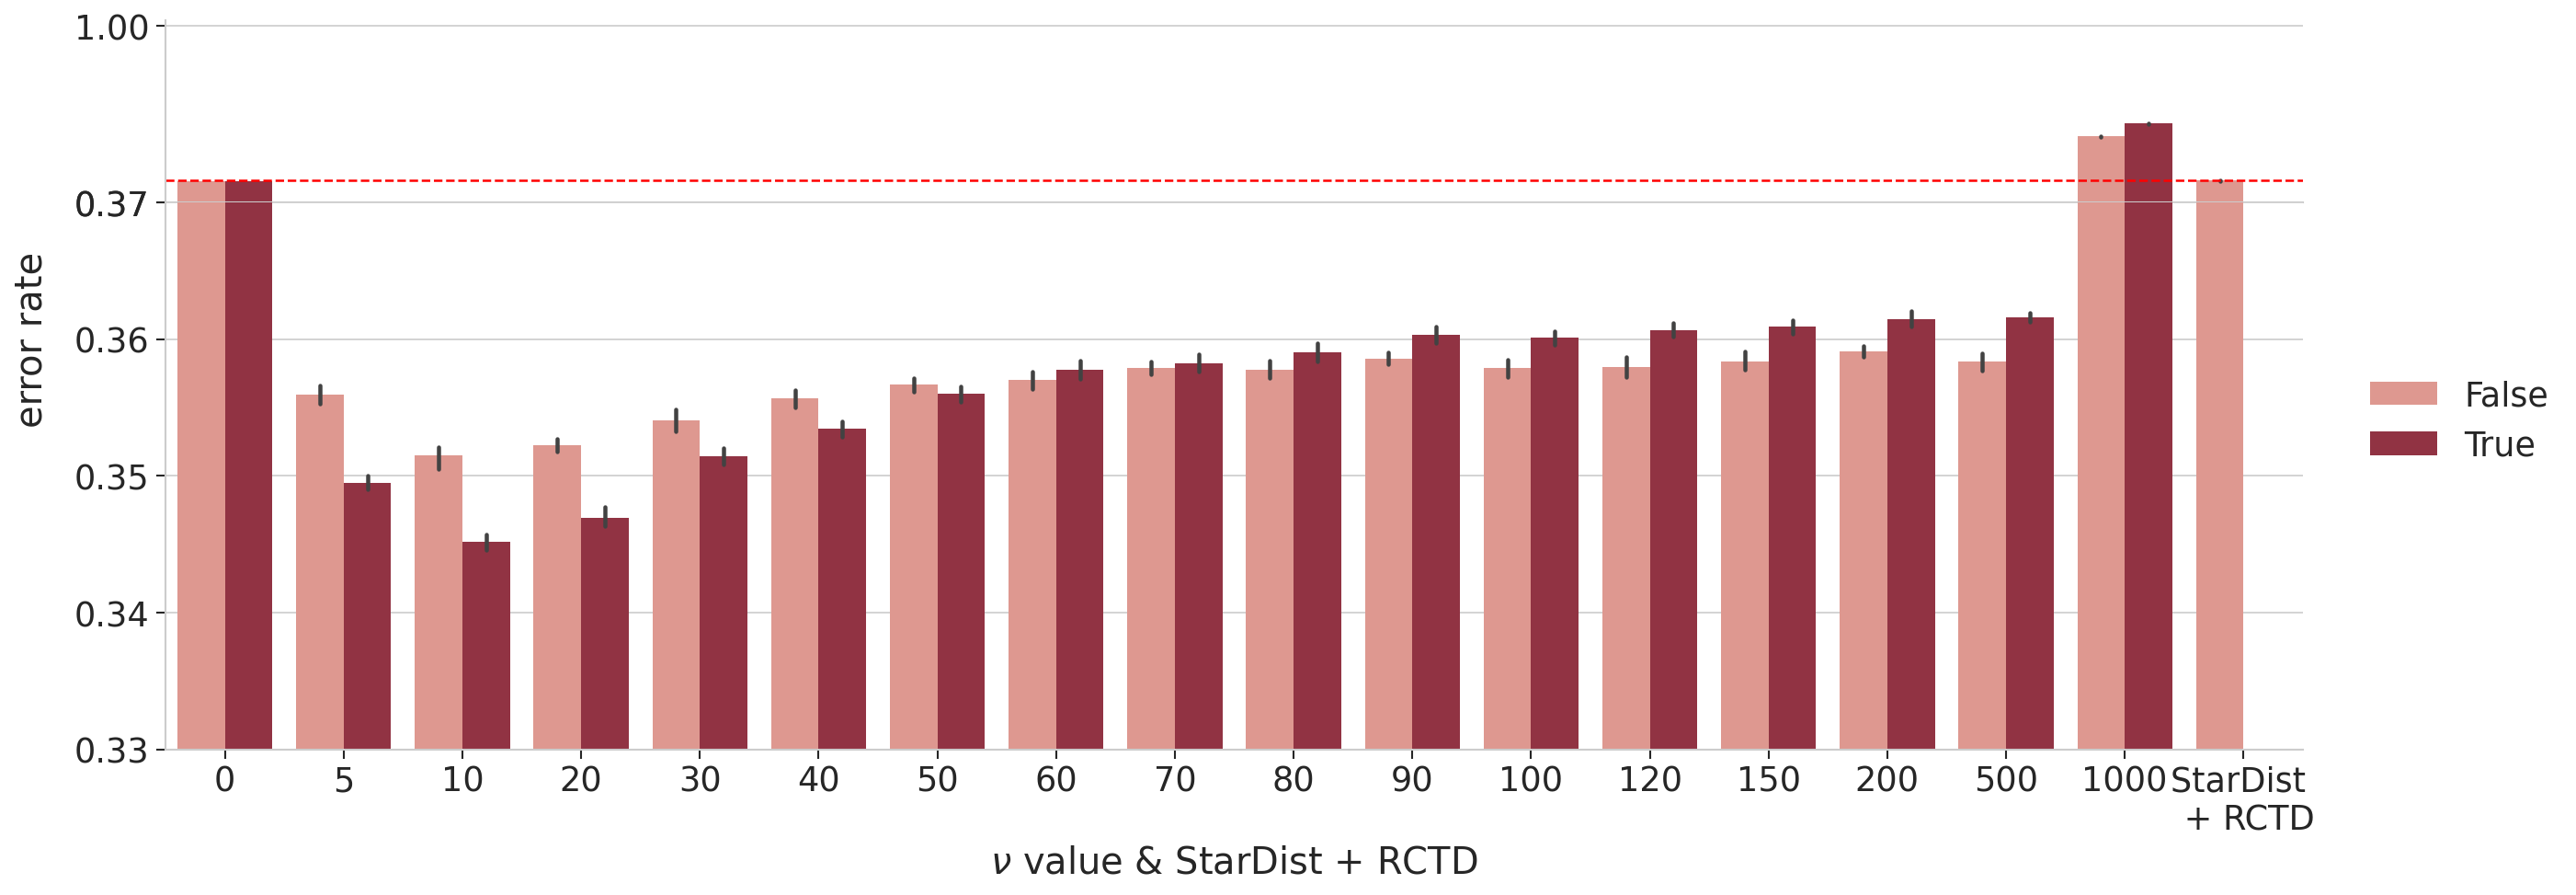

In [297]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(2,1, figsize = (20, 7), dpi = 150, gridspec_kw={'height_ratios': [1, 3]})

palette = ['#EB8E83', '#A02439'] #* (len(vis_nu_list) - 2) + ['#D8A8EB']
with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[0])
ax[0].set_ylim(0.37,1.02)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticks([0.37, 1.0])
# ax[0].set_xticks([])

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[1])
ax[1].set_ylim(0.33,0.37)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_yticks([0.33, 0.34, 0.35, 0.36, 0.37])

ax[0].set_ylabel("")
ax[1].set_ylabel("")

ax[0].get_legend().remove()

ax[0].xaxis.tick_top()
ax[1].xaxis.tick_bottom()

ax[1].legend(loc=(1.025, 0.5))

fig.text(0.07, 0.55, "error rate", va="center", rotation="vertical")
ax[1].set_xticklabels(vis_nu_list)
plt.xlabel(r'$\nu$ value & StarDist + RCTD')
ax[0].axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.subplots_adjust(hspace = 0.0)
plt.show()

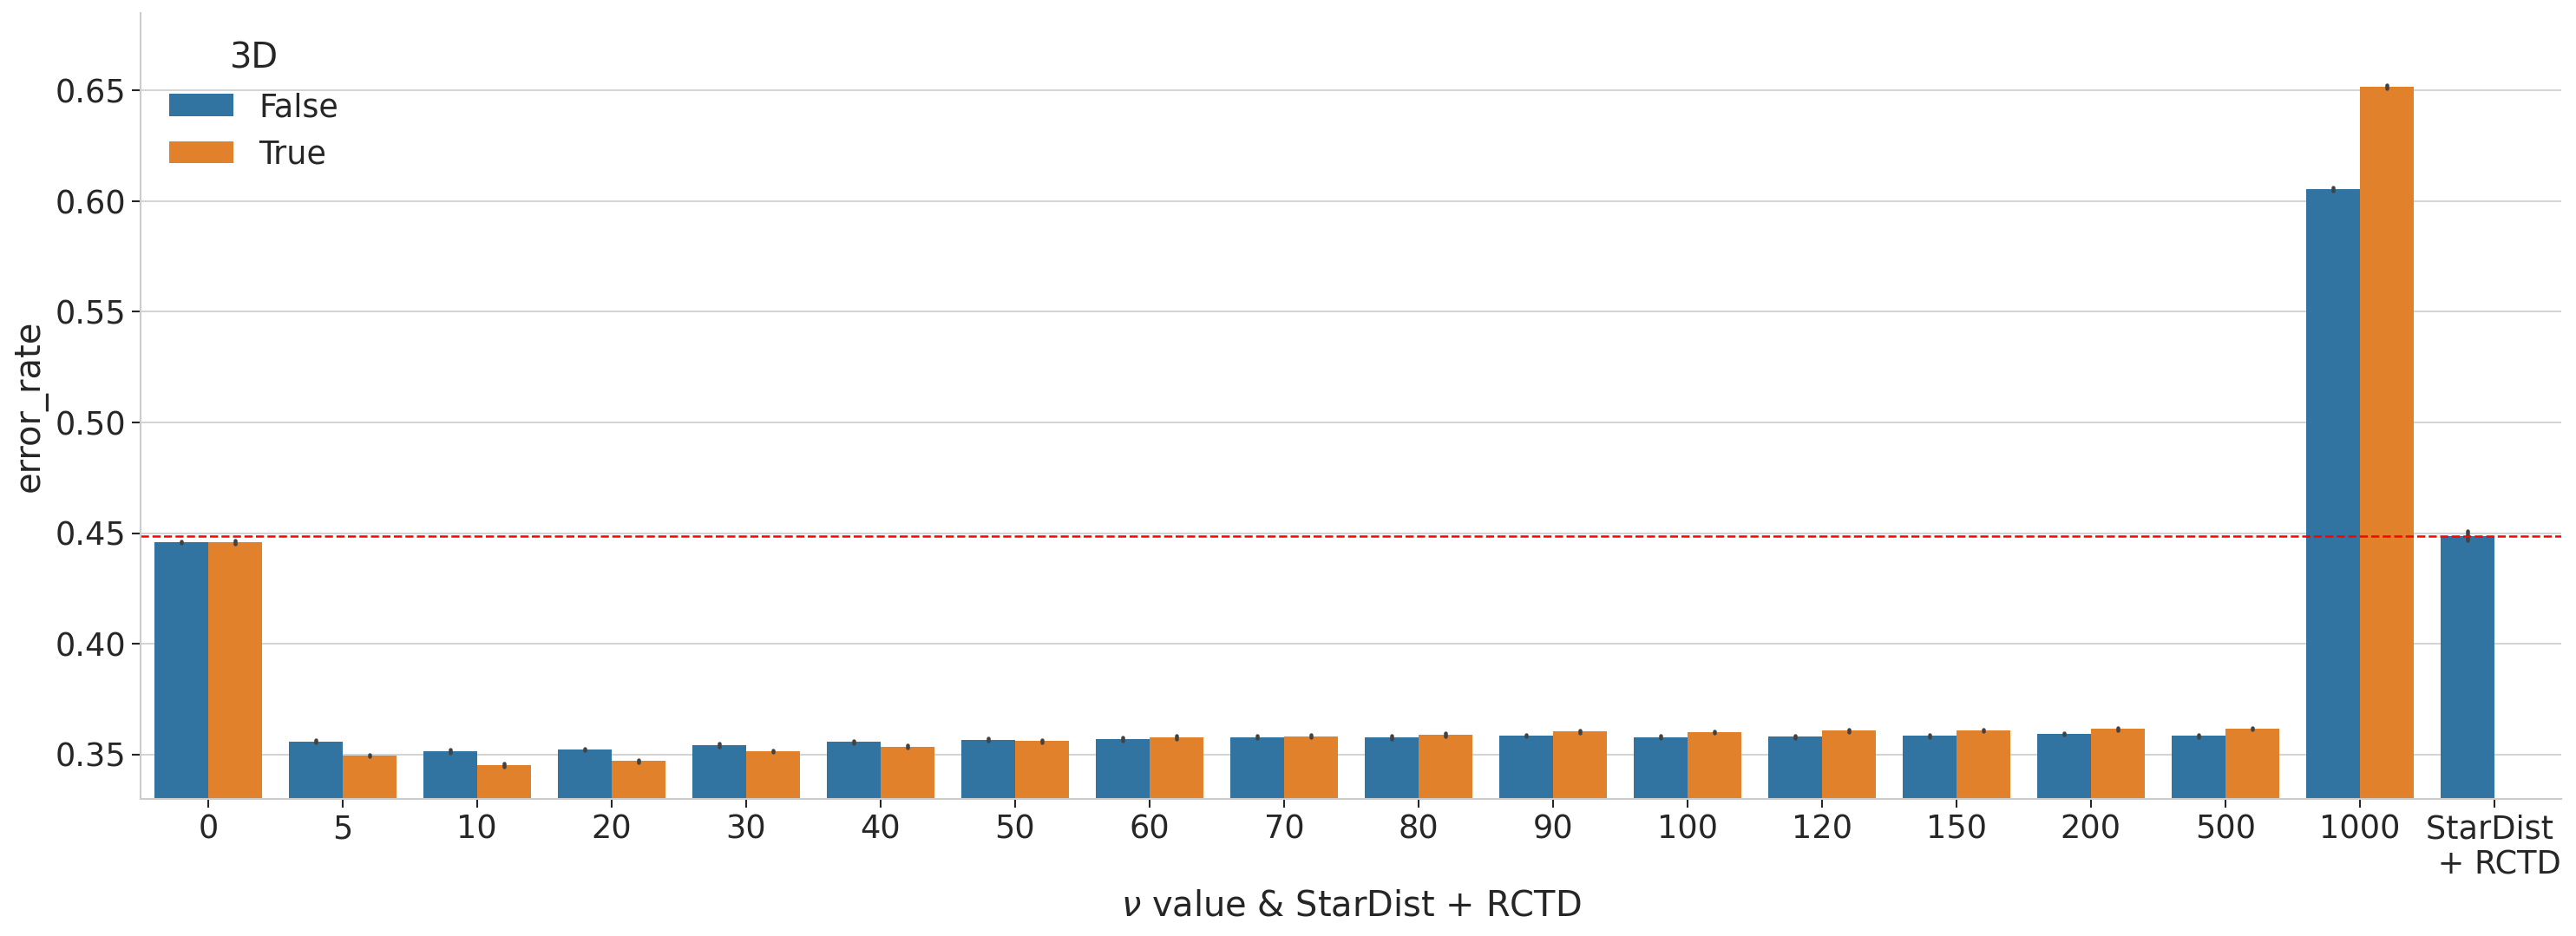

In [246]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (24, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette="tab10", ax = ax)
ax.set_ylim(0.33)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

## deconvolution


In [13]:
decon_df_test = pd.read_csv(os.path.join(DataDir, 'decon_df.csv'), index_col = 0)

In [14]:
temp = decon_df_test.copy()
temp = temp[temp.nu != 1e-6]
temp['nu'] = temp['nu'].astype(int)

vis_decon_df = pd.DataFrame()
vis_decon_df['value'] = temp.RCTD.tolist() + temp.SR.tolist() + temp.SpatialScope.tolist() + temp.SpatialScope_3D.tolist()
vis_decon_df['method'] = ['RCTD'] * temp.shape[0] + ['StarDist+RCTD'] * temp.shape[0] + ['SpatialScope'] * temp.shape[0] + ['SpatialScope_3D'] * temp.shape[0]
vis_decon_df['nu'] = temp.nu.tolist() * 4
vis_decon_df['metric'] = temp.metric.tolist() * 4

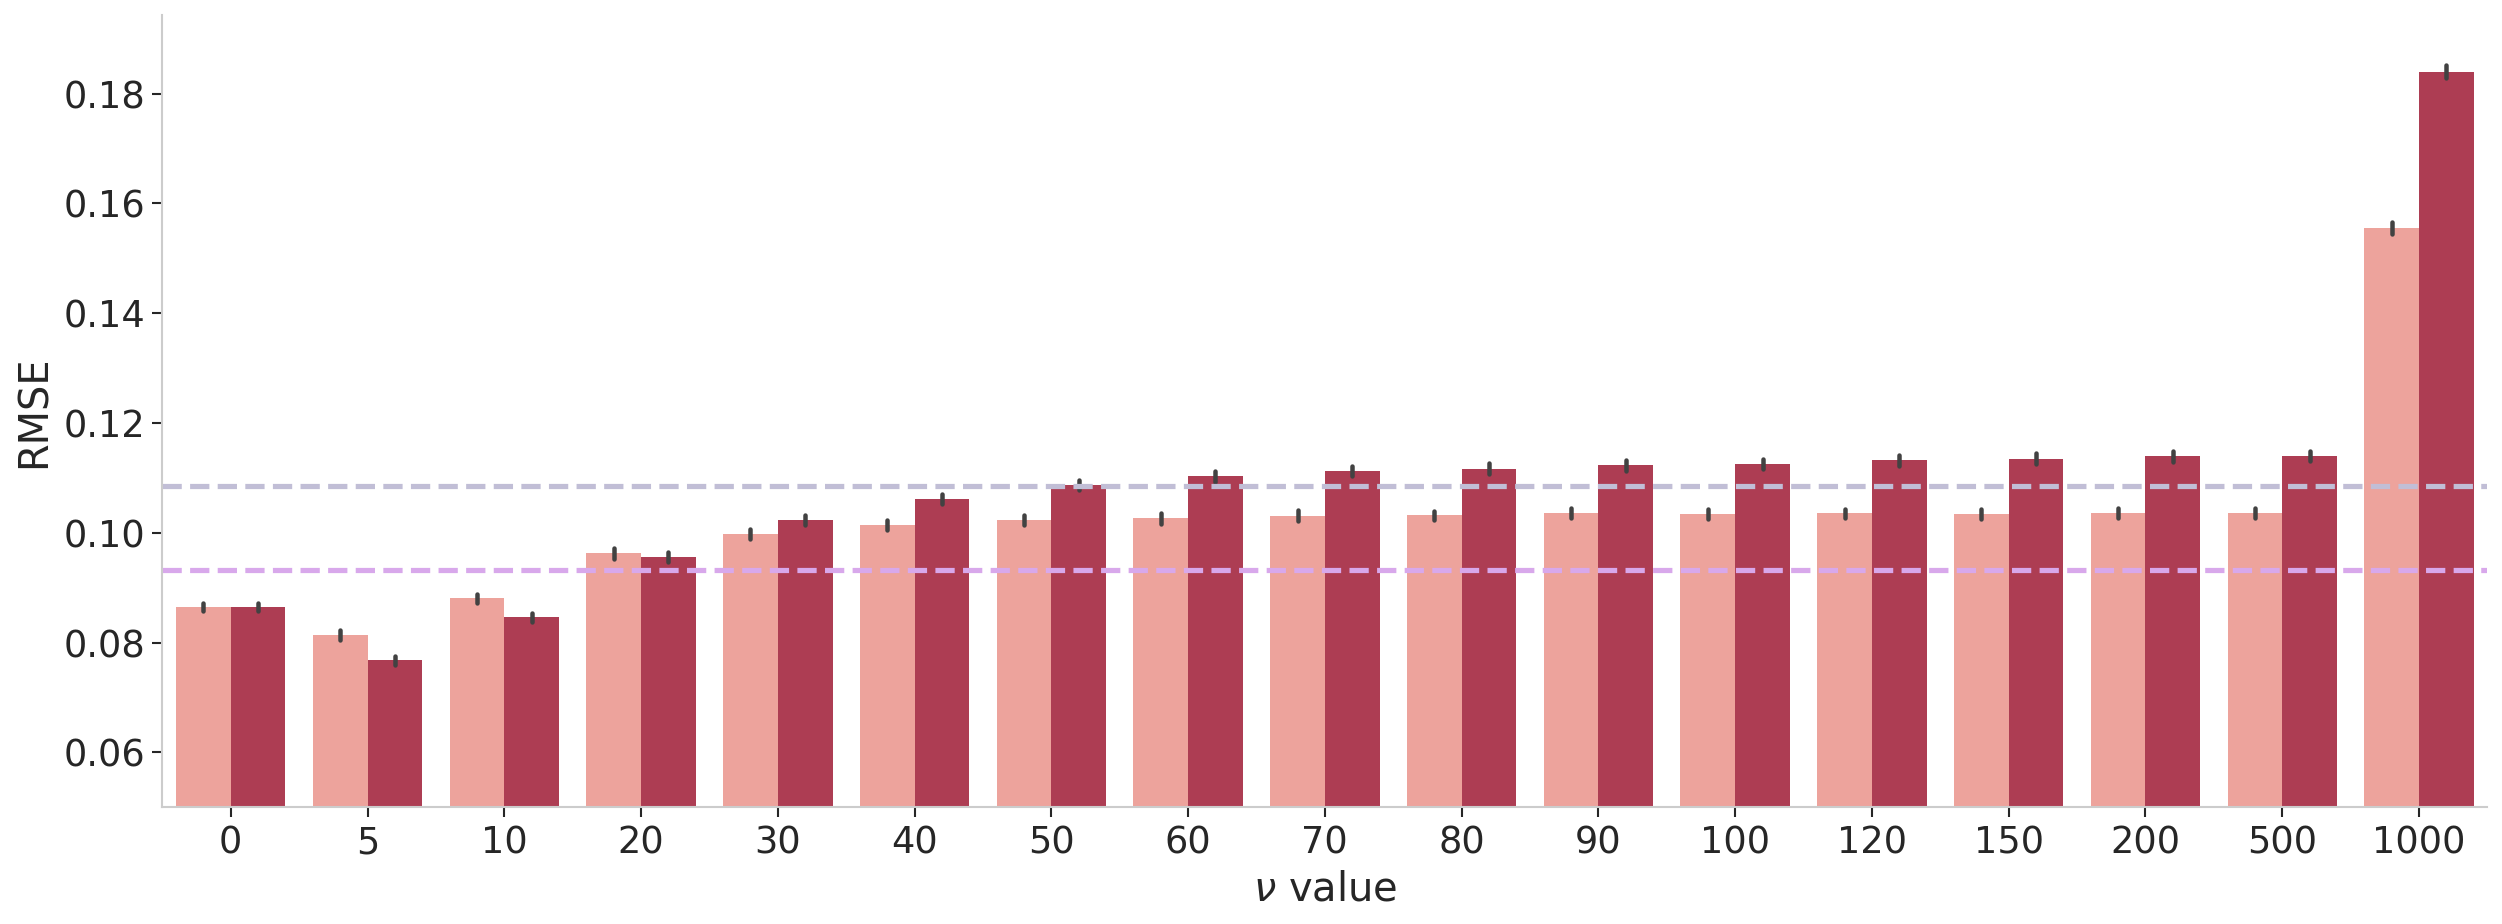

In [53]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'rmse')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value", hue = 'method', data=vis_decon_df[(vis_decon_df.metric == 'rmse') & (vis_decon_df['method'].isin(['SpatialScope', 'SpatialScope_3D']))], width = 0.8, palette=['#FB988E', '#C02A47'], ax = ax)
ax.set_ylim(0.05)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
ax.legend_.remove()
ax.grid(False)
ax.grid(False)
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 2.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 2.5)
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

Text(0.5, 0, '$\\nu$ value')

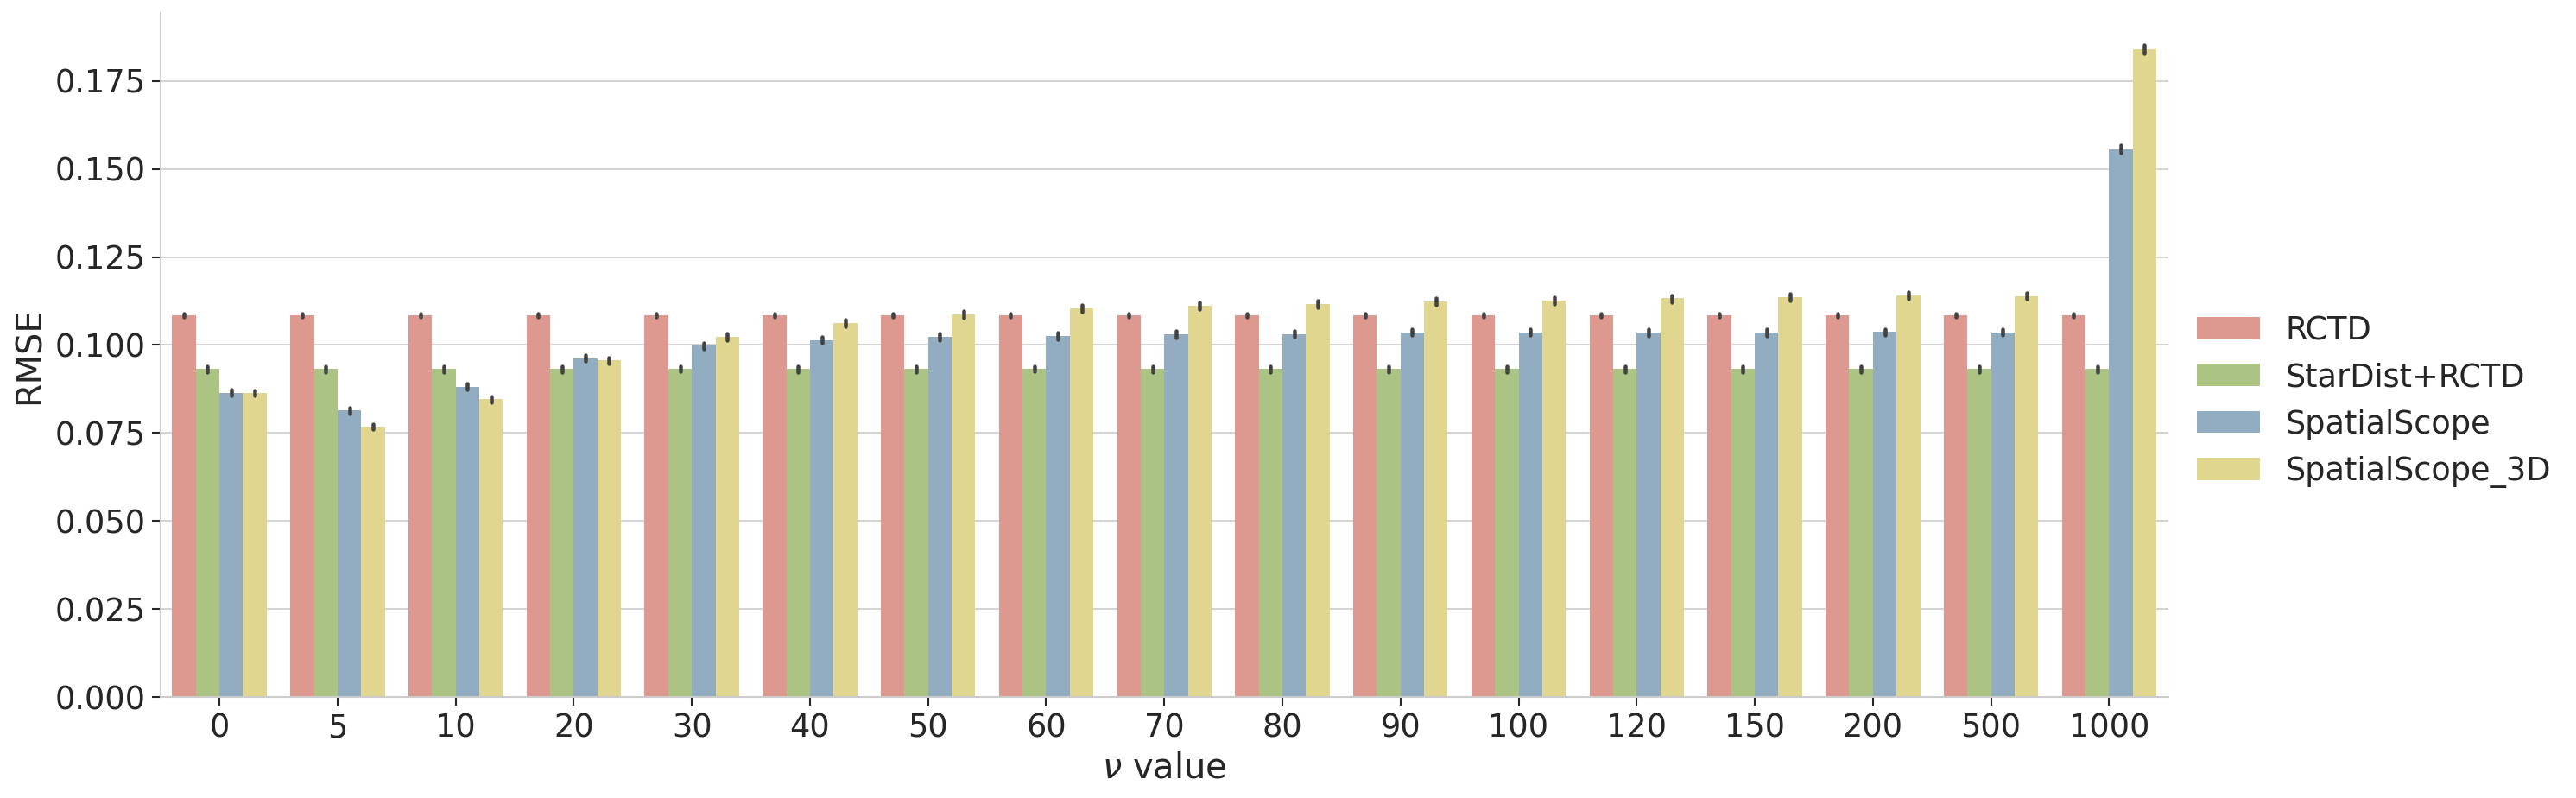

In [25]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'rmse'], palette=['#EA8E83', '#AFCF78', '#8AAEC9', '#EDE081'], ax = ax)
# ax.set_ylim(0.3,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
# plt.show()

Text(0.5, 0, '$\\nu$ value')

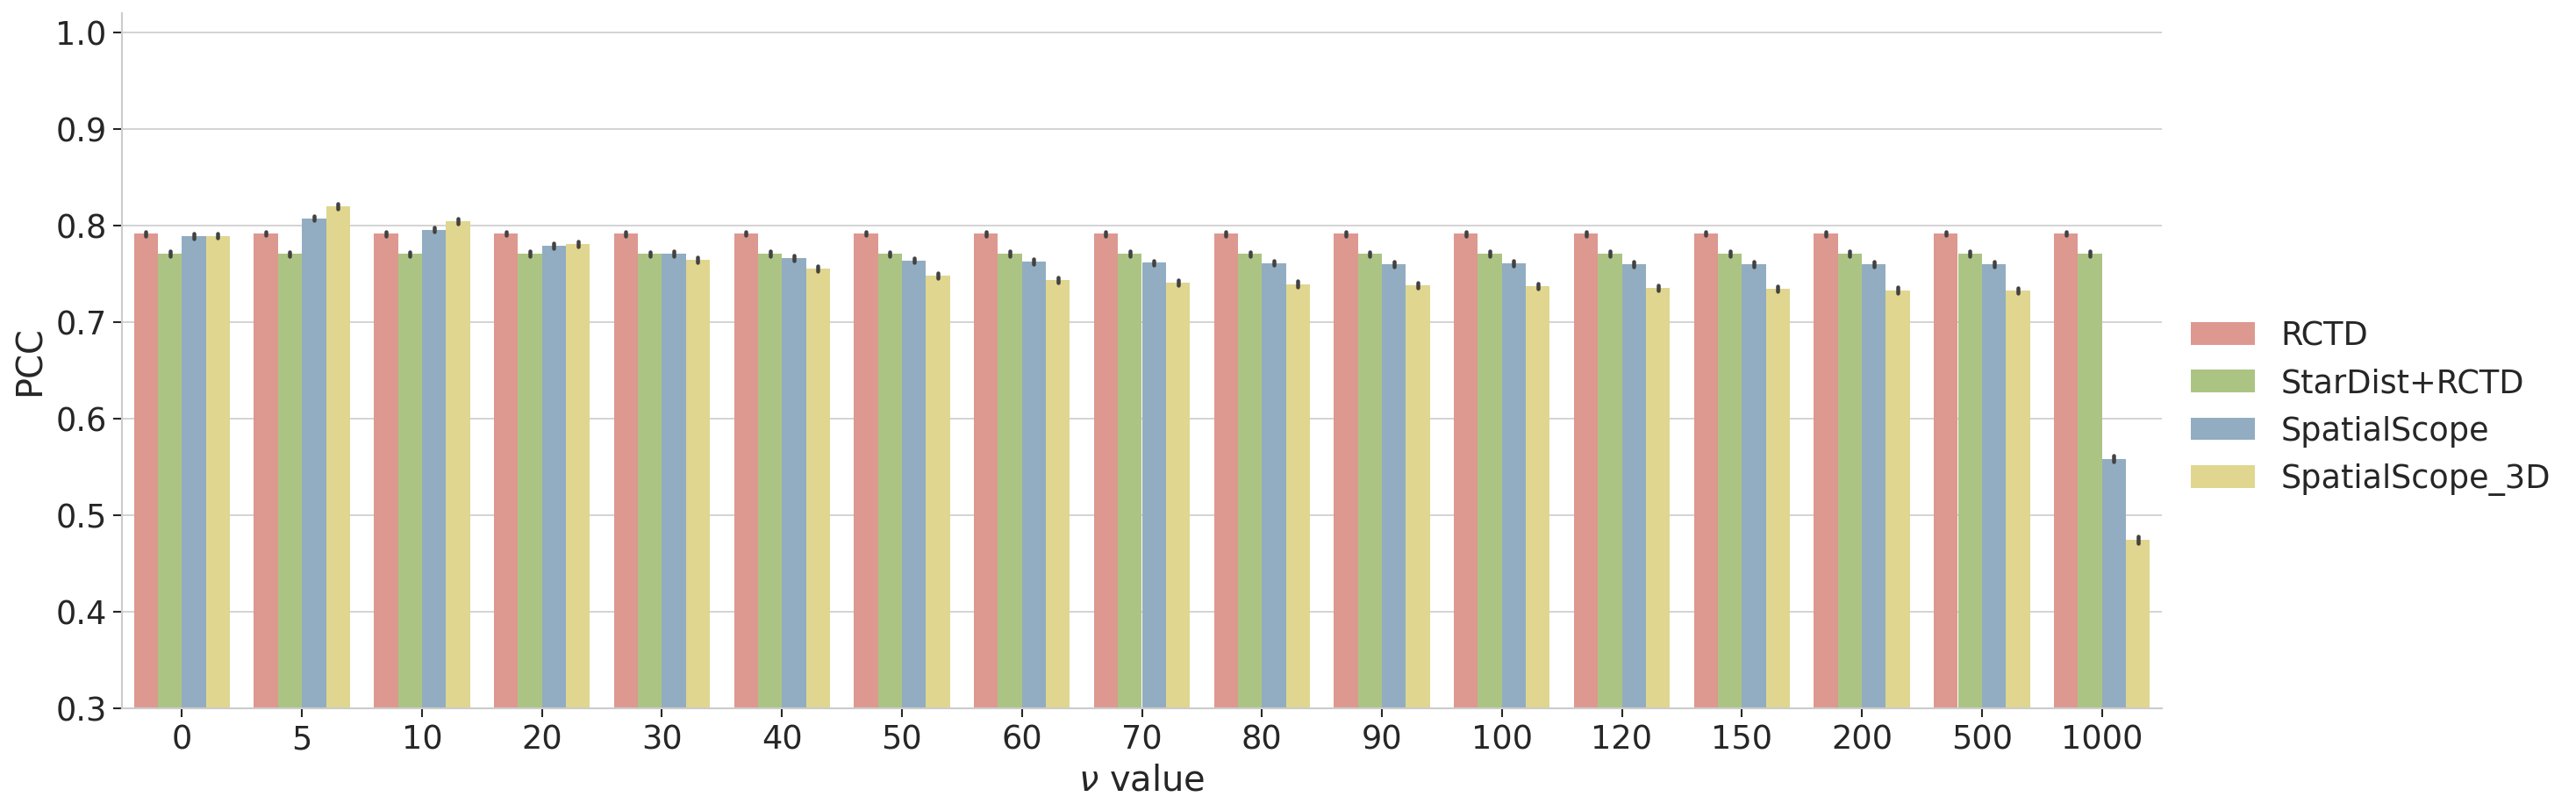

In [226]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'pcc'], palette=['#EA8E83', '#AFCF78', '#8AAEC9', '#EDE081'], ax = ax)
ax.set_ylim(0.3,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
# plt.show()

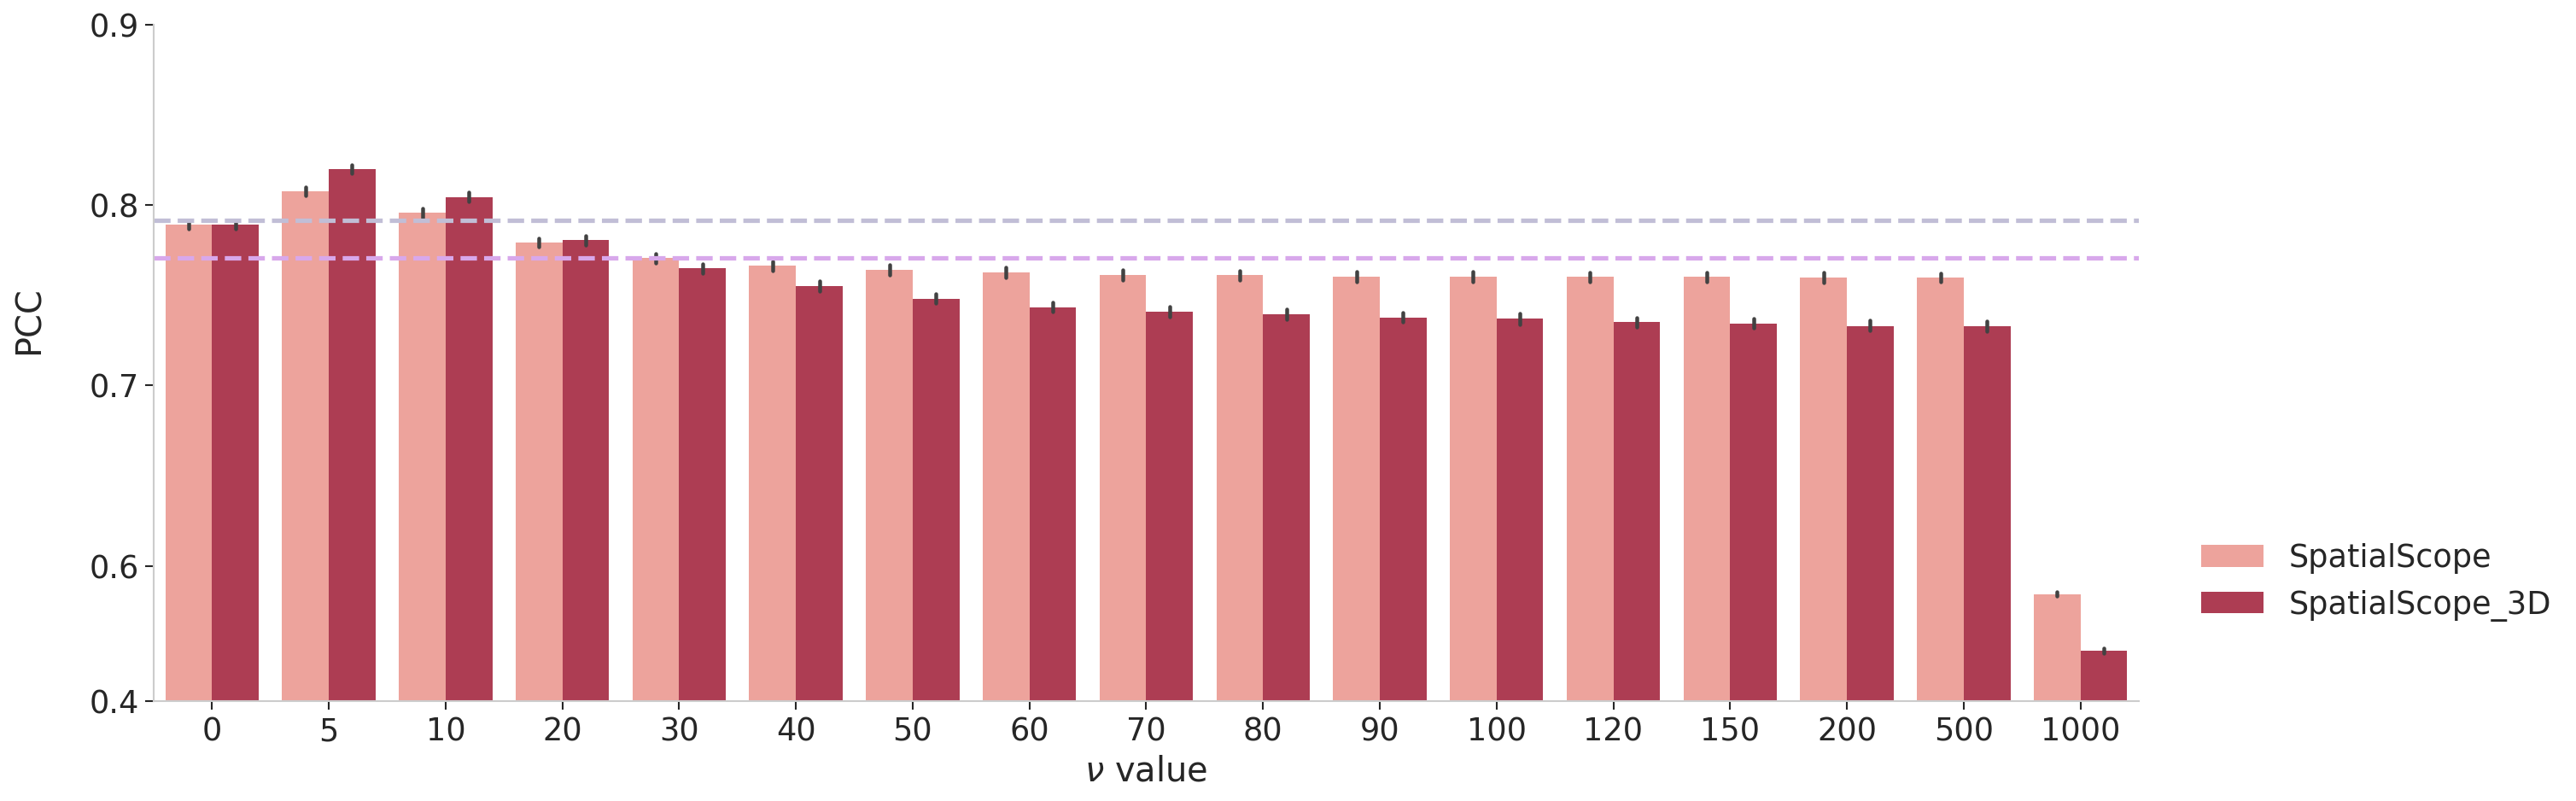

In [47]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(2,1, figsize = (20, 7), dpi = 150, gridspec_kw={'height_ratios': [4, 1]})

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'pcc'], palette=['#EA8E83', '#AFCF78', '#8AAEC9', '#EDE081'], ax = ax[0])
    sns.barplot(x="nu", y="value", hue = 'method', data=vis_decon_df[(vis_decon_df.metric == 'pcc') & (vis_decon_df['method'].isin(['SpatialScope', 'SpatialScope_3D']))], width = 0.8, palette=['#FB988E', '#C02A47'], ax = ax[0])
ax[0].set_ylim(0.6,0.9)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticks([0.6, 0.7, 0.8, 0.9])
# ax[0].set_xticks([])


with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value", hue = 'method', data=vis_decon_df[(vis_decon_df.metric == 'pcc') & (vis_decon_df['method'].isin(['SpatialScope', 'SpatialScope_3D']))], width = 0.8, palette=['#FB988E', '#C02A47'], ax = ax[1])
ax[1].set_ylim(0.4,0.6)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_yticks([0.4])

ax[0].set_ylabel("")
ax[1].set_ylabel("")

ax[0].get_legend().remove()
ax[0].get_xaxis().set_visible(False)
ax[0].spines['bottom'].set_visible(False)

# ax[0].xaxis.tick_top()
# ax[1].xaxis.tick_bottom()

ax[1].legend(loc=(1.025, 0.5))
ax[0].grid(False)
ax[1].grid(False)

ax[0].axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 2.5)
ax[0].axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 2.5)

fig.text(0.07, 0.55, "PCC", va="center", rotation="vertical")
# fig.subplots_adjust(left=0.15, right=0.85, bottom=0, top=0.95)
# plt.legend(bbox_to_anchor=(1,0.6))
# plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
# plt.tight_layout()
plt.subplots_adjust(hspace = 0.0)
plt.show()

## example results

In [407]:
nu = 10
cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', 'rep' + str(0), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)
cell_locations_3D = pd.read_csv(os.path.join(DataDir, 'rep' + str(0), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

SR_results = sc.read(os.path.join(DataDir, 'rep' + str(0), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
SR_cell_type_label = SR_results.uns['cell_locations'].copy()

## ground truth

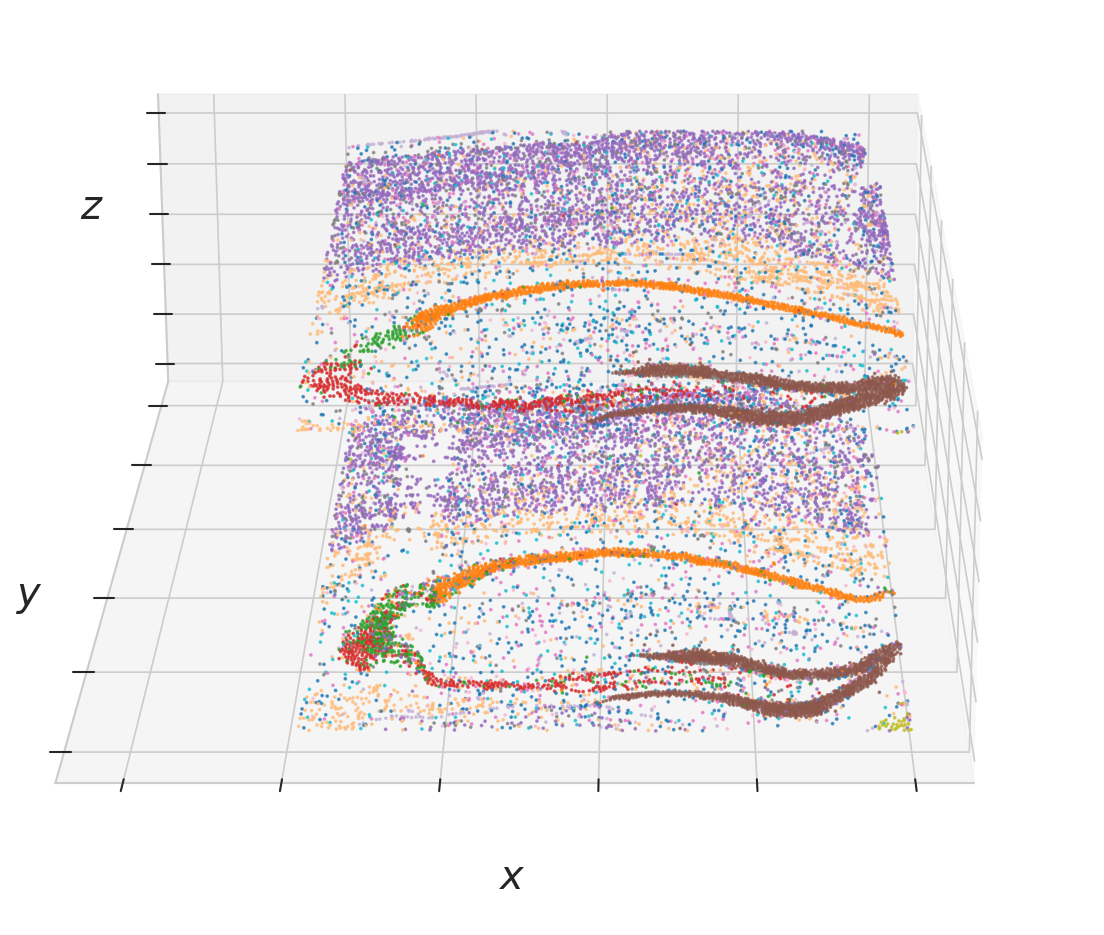

In [408]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z'])

plt.figure(figsize=(20, 8),dpi = 150)
ax = plt.subplot(1,1,1, projection='3d')

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

scatter = ax.scatter(x1, y1, z1, c=cell_locations_3D[sp_cell_class_column].map(color_dict), s=1., alpha=0.7)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="cell number")

# legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'),
#                     loc="upper right", title="leiden", markerscale = 2)
# ax.add_artist(legend1)

ax.view_init(20,-90)
plt.show()

## SpatialScope

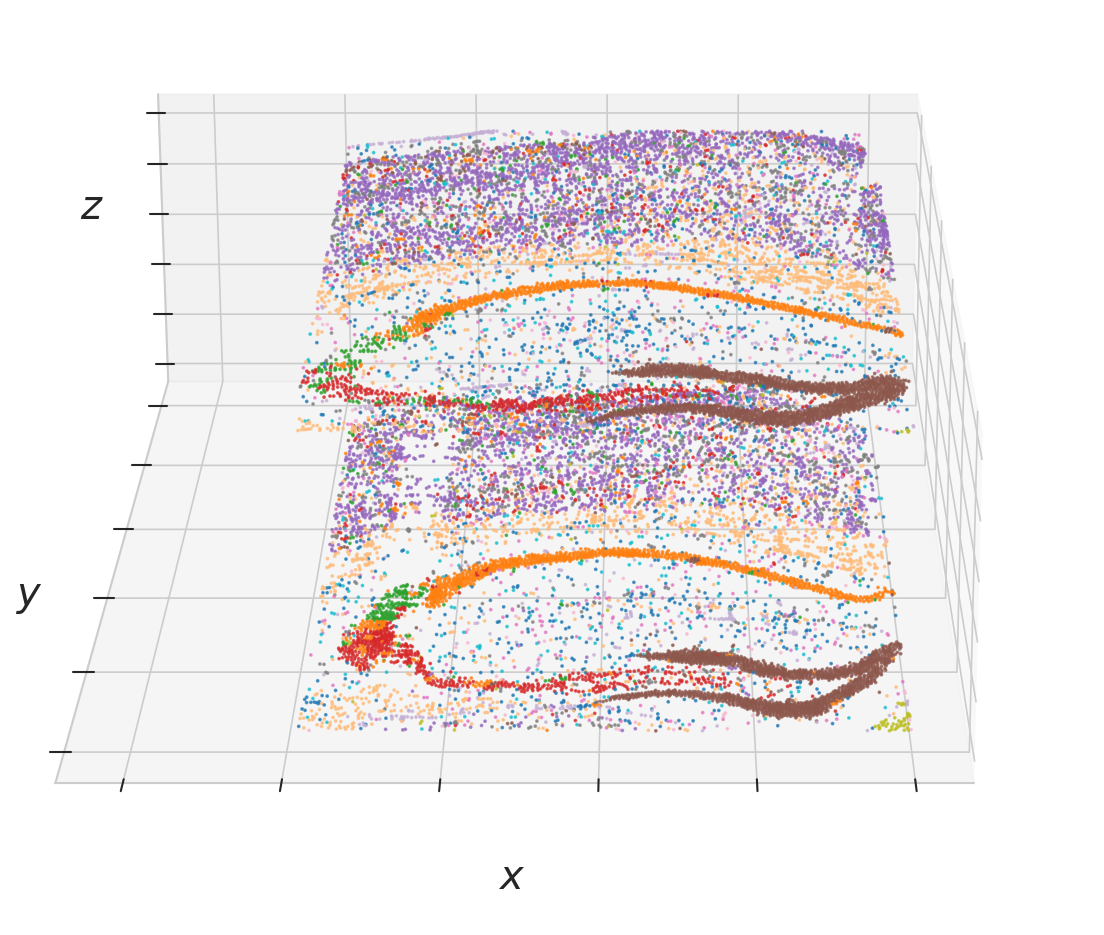

In [409]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z'])

plt.figure(figsize=(20, 8),dpi = 150)
ax = plt.subplot(1,1,1, projection='3d')

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

scatter = ax.scatter(x1, y1, z1, c=cell_locations['discrete_label_ct'].map(color_dict), s=1., alpha=0.7)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="cell number")

# legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'),
#                     loc="upper right", title="leiden", markerscale = 2)
# ax.add_artist(legend1)

ax.view_init(20,-90)
plt.show()

# SpatialScope 3D

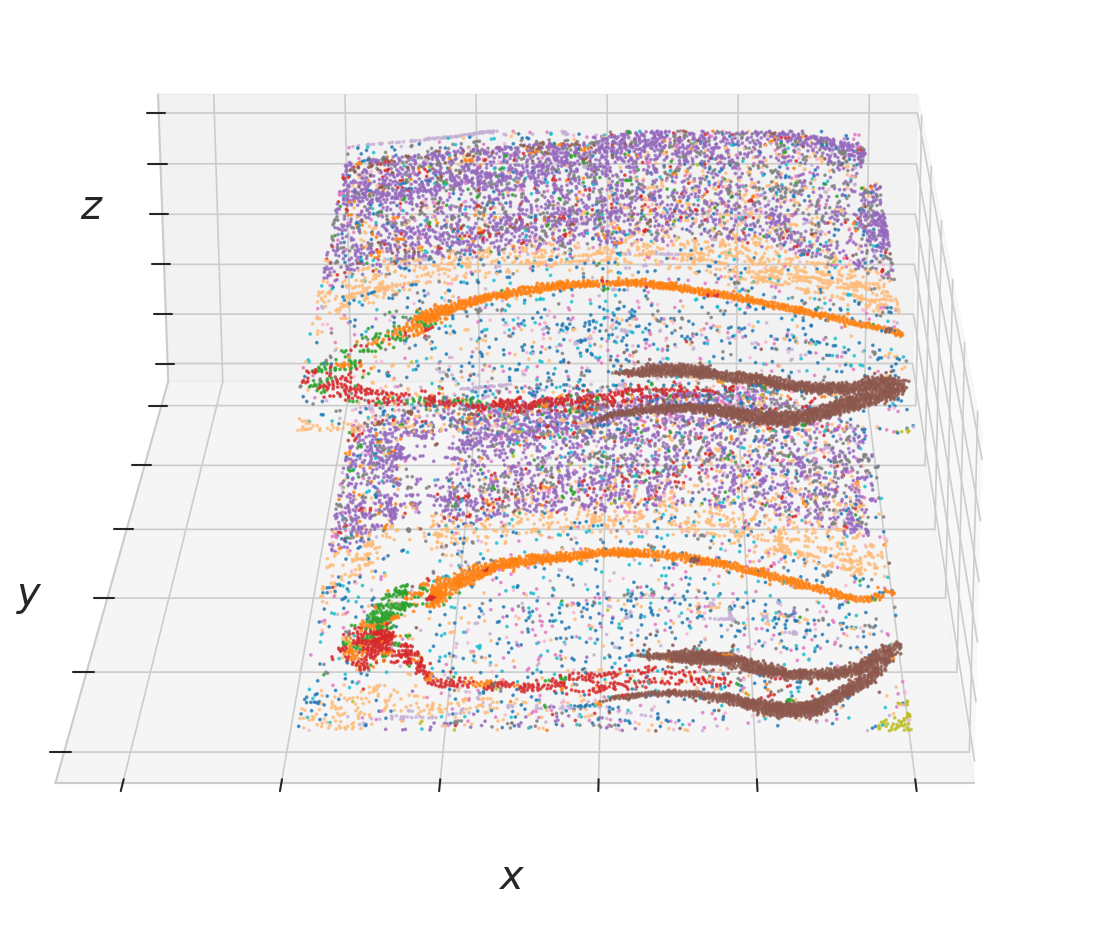

In [410]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z'])

plt.figure(figsize=(20, 8),dpi = 150)
ax = plt.subplot(1,1,1, projection='3d')

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

scatter = ax.scatter(x1, y1, z1, c=cell_locations_3D['discrete_label_ct'].map(color_dict), s=1., alpha=0.7)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="cell number")

# legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'),
#                     loc="upper right", title="leiden", markerscale = 2)
# ax.add_artist(legend1)

ax.view_init(20,-90)
plt.show()

### StarDist + RCTD 

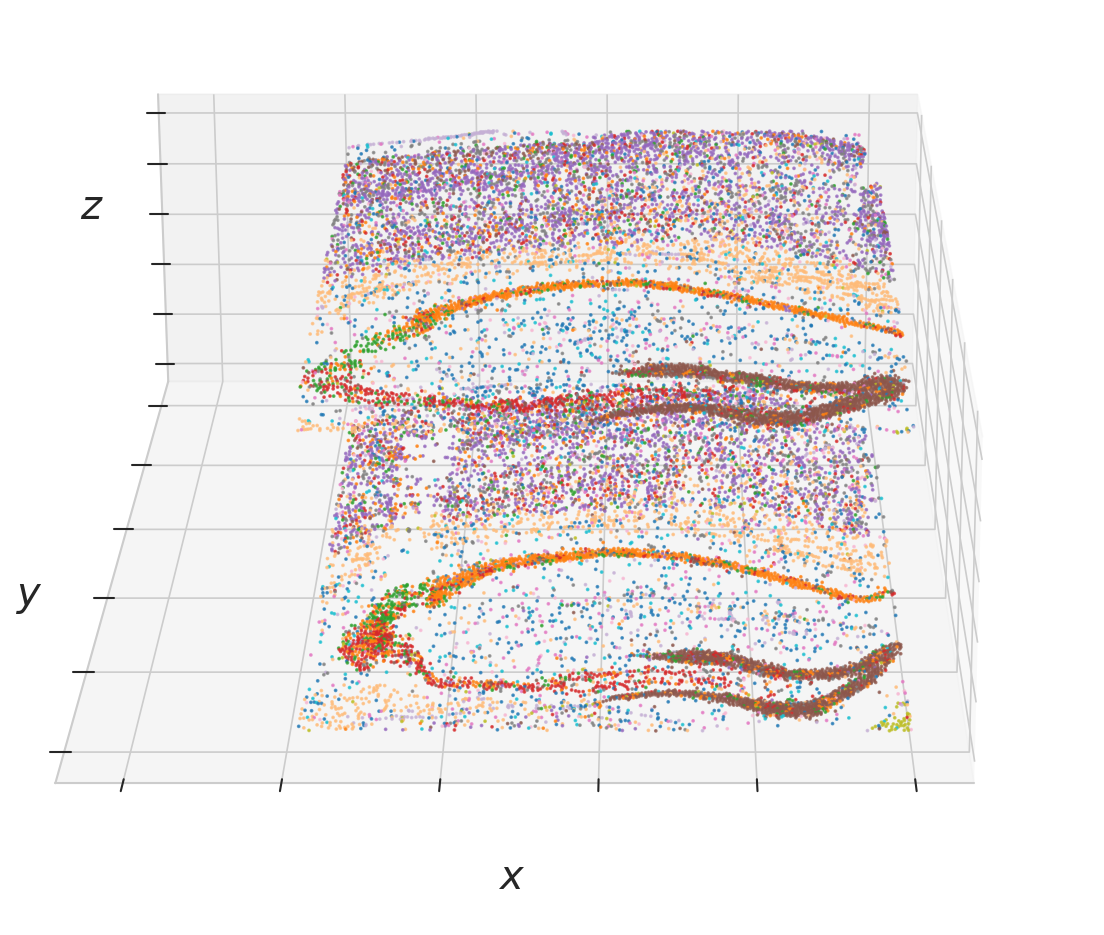

In [411]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1,y1,z1 = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z'])

plt.figure(figsize=(20, 8),dpi = 150)
ax = plt.subplot(1,1,1, projection='3d')

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 2, 0.8, 1]))

scatter = ax.scatter(x1, y1, z1, c=SR_cell_type_label['SDRCTD_cell_type'].map(color_dict), s=1., alpha=0.7)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="cell number")

# legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'),
#                     loc="upper right", title="leiden", markerscale = 2)
# ax.add_artist(legend1)

ax.view_init(20,-90)
plt.show()